# Imports and data loading

In [1]:
import os
os.chdir("/home2/jgcw74/l3_project")  # go to project root for local imports

import helpers
import xai

/home2/jgcw74/l3_project/helpers/ml.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import typing as t

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
AVAILABLE_MODELS = ("ConvNeXtSmall", "ResNet50", "SwinTransformerSmall")

pd.options.display.precision = 5
pd.options.display.max_colwidth = 20
pd.options.display.max_columns = None
pd.options.display.width = 225

plt.style.use('seaborn-v0_8-paper')

## Load data into multi-indexed dataframe

In [4]:
dfs = dict()
for explainer_name in t.get_args(xai.EXPLAINER_NAMES):
    results_for_exp = dict()
    h5_output_path = helpers.env_var.get_project_root() / "results" / explainer_name / "evaluation_output.h5"
    store = pd.HDFStore(str(h5_output_path), mode="r")
    for key_name in store.keys():
        table_name = key_name.strip("/")
        df: pd.DataFrame = store[table_name]
        if df.isna().sum().sum() != 0:
            raise RuntimeError("A results table contains NaN values!")
        else:
            # adjust value in line with methodology formula and updated output_completeness.py
            df["output_completeness : preservation_check_conf_drop"] = 1 - df["output_completeness : preservation_check_conf_drop"]

            results_for_exp[table_name] = df
    dfs[explainer_name] = results_for_exp
    store.close()
for key in dfs.keys():
    print(f"{key}: {len(dfs[key])} tables loaded")

PartitionSHAP: 12 tables loaded
GradCAM: 12 tables loaded
KPCACAM: 12 tables loaded


In [5]:
# ew = pd.ExcelWriter("all_results_export.xlsx")
big_df_dict = dict()
for sheet_name, df_dict in dfs.items():
    temp_df = pd.concat(df_dict).reset_index()
    temp_df["dataset"] = temp_df["level_0"].str.split("_").str.get(0)
    temp_df["model"] = temp_df["level_0"].str.split("_").str.get(1)
    temp_df = temp_df.rename(columns={"level_1": "class_label"}).set_index(["dataset", "model", "class_label"]).drop(["level_0"], axis="columns")

    # temp_df.to_excel(ew, sheet_name=sheet_name, index=True, merge_cells=False)

    big_df_dict[sheet_name] = temp_df
# ew.close()

In [6]:
xai_ds_m_c_df = pd.concat(big_df_dict.values(), keys=big_df_dict.keys(), names=["xai_method"])
xai_ds_m_c_df = xai_ds_m_c_df.drop(
    columns=xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.startswith("continuity") | xai_ds_m_c_df.columns.str.endswith("l2_distance")]
)  # drop columns that are not being used for the analysis
xai_ds_m_c_df.columns = xai_ds_m_c_df.columns.str.replace("randomised_model_similarity", "random_sim").str.replace("adversarial_attack_similarity", "adv_attk_sim").str.replace("correctness", "COR").str.replace("output_completeness", "O-C").str.replace("contrastivity", "CON").str.replace("compactness", "COM").str.replace("spearman_rank", "SR").str.replace("top_k_intersection", "top_m").str.replace("structural_similarity", "ssim")
xai_ds_m_c_df = xai_ds_m_c_df.replace(-np.inf, np.nan)
xai_ds_m_c_df.columns, xai_ds_m_c_df.index[-1]

(Index(['COR : random_sim : SR', 'COR : random_sim : top_m', 'COR : random_sim : ssim', 'COR : incremental_deletion_auc_ratio', 'O-C : deletion_check_conf_drop', 'O-C : preservation_check_conf_drop',
        'CON : adv_attk_sim : SR', 'CON : adv_attk_sim : top_m', 'CON : adv_attk_sim : ssim', 'COM : threshold_score'],
       dtype='object'),
 ('KPCACAM', 'UCMerced', 'SwinTransformerSmall', 'tenniscourt'))

In [7]:
xai_ds_m_c_df.head(10)

COR : random_sim : SR  COR : random_sim : top_m  COR : random_sim : ssim  COR : incremental_deletion_auc_ratio  O-C : deletion_check_conf_drop  \
xai_method    dataset   model         class_label                                                                                                                                                            
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.00523                0.14878                   0.41432                  0.96003                               0.02158              
                                      Forest                           -0.07230                0.07800                   0.40101                  0.99792                               0.00165              
                                      HerbaceousVegetation             -0.04666                0.10900                   0.39492                  0.90204                               0.05134              
                                      Highway                          -0.10270                0.10998                   0.37283                  0.21928                               0.77958              
                                      Industrial                        0.02080                0.12305                   0.39885                  0.57631                               0.26537              
                                      Pasture                          -0.08098                0.13545                   0.38855                  0.77756                               0.12203              
                                      PermanentCrop                     0.01643                0.12518                   0.39428                  0.60866                               0.08166              
                                      Residential                      -0.01304                0.08723                   0.37242                  0.45793                               0.16066              
                                      River                             0.08319                0.24618                   0.44647                  0.53516                               0.35813              
                                      SeaLake                           0.13131                0.19157                   0.44517                  0.99711                               0.00330              

                                                            O-C : preservation_check_conf_drop  CON : adv_attk_sim : SR  CON : adv_attk_sim : top_m  CON : adv_attk_sim : ssim  COM : threshold_score  
xai_method    dataset   model         class_label                                                                                                                                                      
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.02569                            -0.28210                  0.06224                     0.36607                    0.95654    
                                      Forest                            0.00023                            -0.33116                  0.10560                     0.37584                    0.98035    
                                      HerbaceousVegetation              0.02447                            -0.37321                  0.09153                     0.35002                    0.95605    
                                      Highway                           0.78082                             0.23690                  0.35820                     0.51630                    0.97015    
                                      Industrial                        0.39112                             0.13593                  0.17175                     0.45784                    0.89087    
                                      Pasture                           0.14261                            -0.22556                  0.14977                     0.39108                   

# Sanity check correctness (random_sim)

We want this to be low across all 3 similarity metrics if the explanation accurately reflects the model's behaviour.

In [22]:
cor_rs_cols = xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.contains("COR : random_sim")]
cor_rs_df: pd.DataFrame = xai_ds_m_c_df[cor_rs_cols]
cor_rs_df.head(10)

COR : random_sim : SR  COR : random_sim : top_m  COR : random_sim : ssim
xai_method    dataset   model         class_label                                                                                   
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.00523                0.14878                   0.41432    
                                      Forest                           -0.07230                0.07800                   0.40101    
                                      HerbaceousVegetation             -0.04666                0.10900                   0.39492    
                                      Highway                          -0.10270                0.10998                   0.37283    
                                      Industrial                        0.02080                0.12305                   0.39885    
                                      Pasture                          -0.08098                0.13545                   0.38855    
                                      PermanentCrop                     0.01643                0.12518                   0.39428    
                                      Residential                      -0.01304                0.08723                   0.37242    
                                      River                             0.08319                0.24618                   0.44647    
                                      SeaLake                           0.13131                0.19157                   0.44517

<Axes: xlabel='xai_method,dataset'>

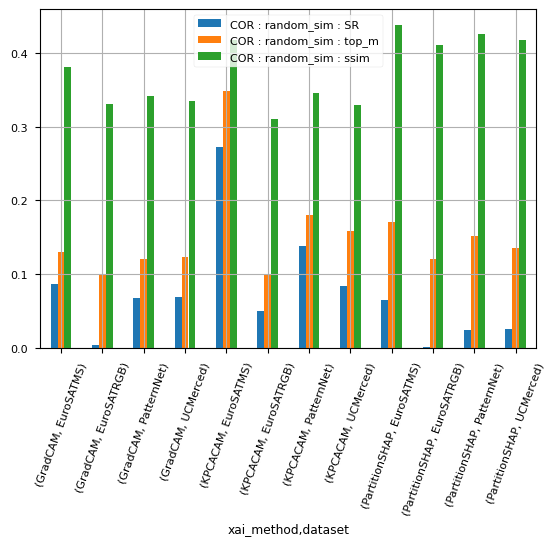

In [24]:
cor_rs_df.groupby(level=["xai_method", "dataset"]).mean().plot(kind="bar", rot=70, grid=True)

KPCA seems suspicious here on EuroSATMS

<Axes: xlabel='model'>

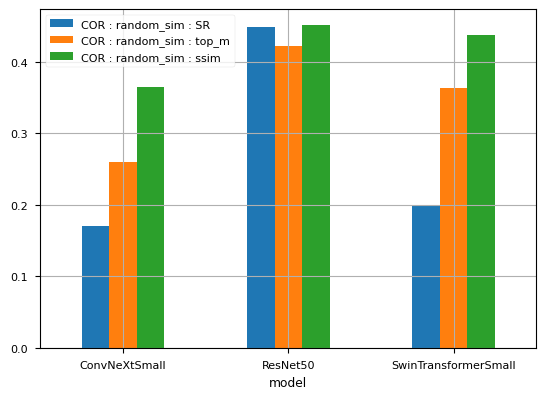

In [25]:
cor_rs_df.loc["KPCACAM", "EuroSATMS"].groupby("model").mean().plot(kind="bar", rot=0, grid=True)

Suggests that KPCACAM is not a faithful explainer for ResNet50 on EuroSATMS.

<Axes: xlabel='class_label'>

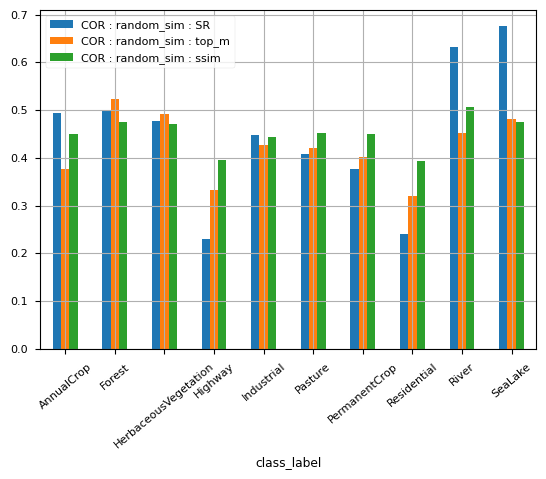

In [29]:
cor_rs_df.loc["KPCACAM", "EuroSATMS", "ResNet50"].plot(kind="bar", rot=40, grid=True)

Appears to be worst for River and SeaLake

# Correctness (incremental_deletion_auc_ratio)

We want this to be low (but might vary a lot by dataset and classes depending on object/land type) with 0 best and above 1 means random deletion was better.

In [8]:
cor_id_cols = xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.contains("COR : incremental_deletion_auc_ratio")]
cor_id_df: pd.DataFrame = xai_ds_m_c_df[cor_id_cols]
cor_id_df.columns

Index(['COR : incremental_deletion_auc_ratio'], dtype='object')

In [9]:
def colour_code_high_bars(threshold):
    ax = plt.gca()

    ax.axhline(threshold, color="r", linestyle="--")

    # Get all bar containers in the current plot
    containers = [c for c in ax.containers]
    heights = [p.get_height() for c in containers for p in c.patches]

    for container in containers:
        for patch in container.patches:
            height = patch.get_height()
            if height > threshold:
                # Calculate intensity based on how much it exceeds the threshold
                # Capping at 0.9 to avoid completely black bars
                ratio = max((height - threshold) / (max(heights) - threshold), 0.2)
                # Create a darker shade of red the higher the value
                color = (1.0, 1.0 - ratio, 1.0 - ratio)
                patch.set_facecolor(color)

### Hardest dataset classes

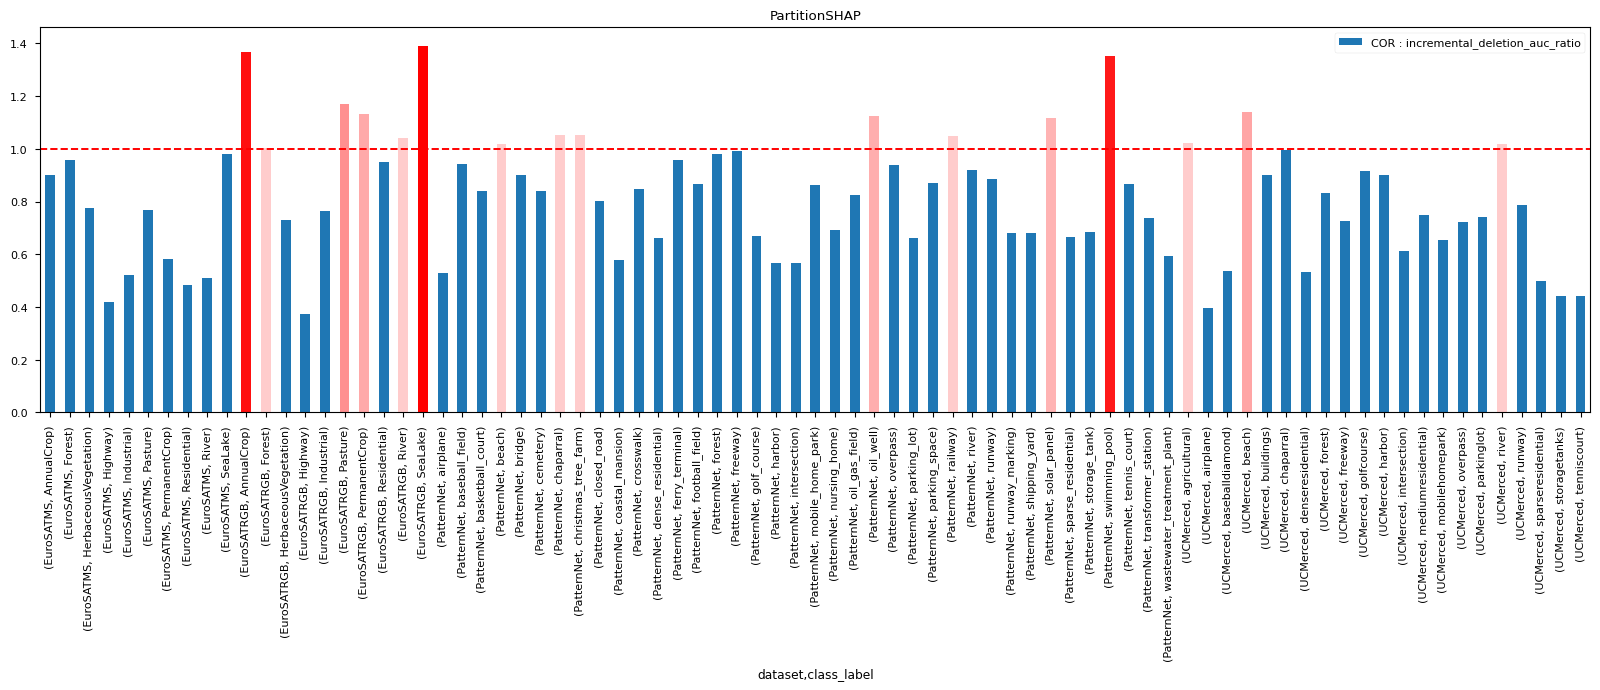

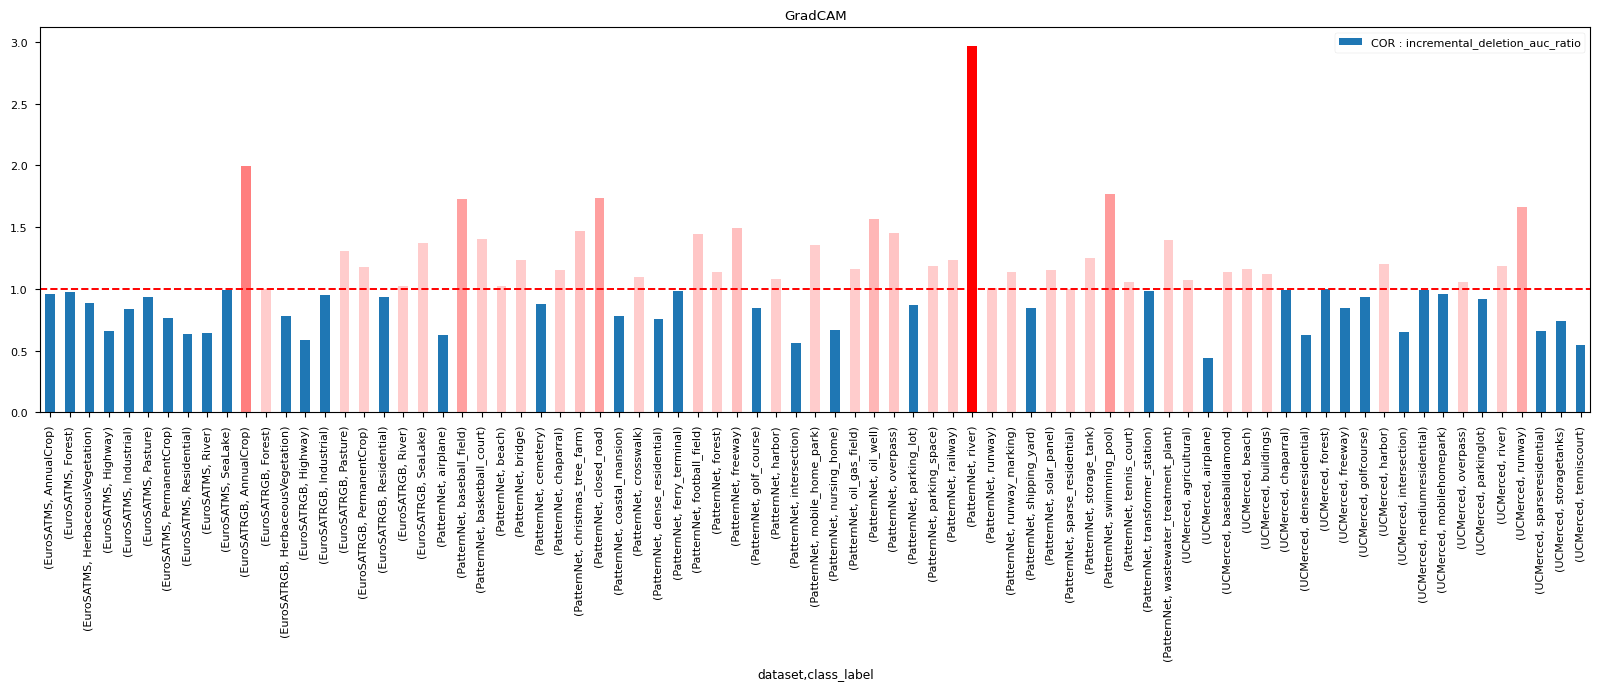

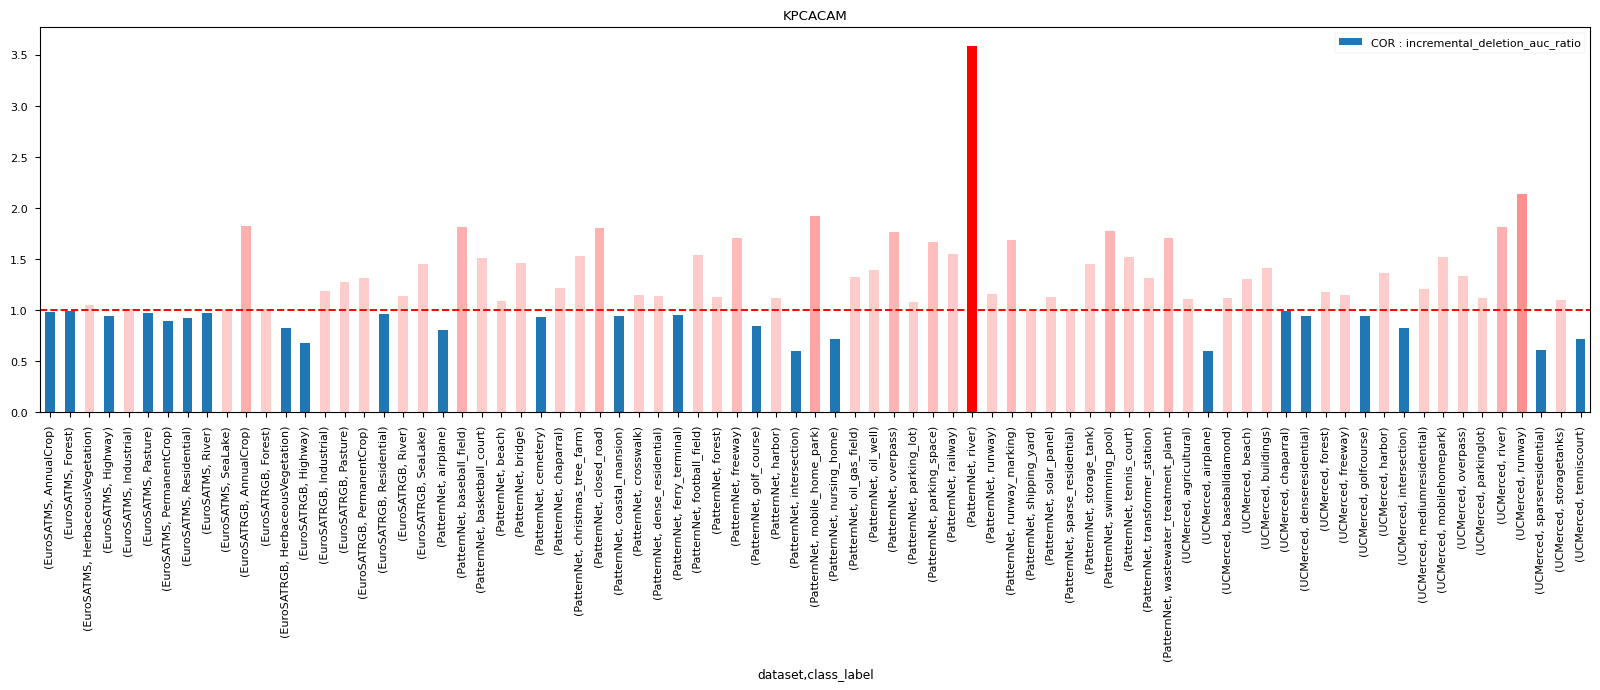

In [48]:
for e_name in t.get_args(xai.EXPLAINER_NAMES):
    cor_id_df.loc[e_name].groupby(level=["dataset", "class_label"]).mean().plot(kind="bar", figsize=(20, 5), title=e_name)
    colour_code_high_bars(1)
    plt.show()

In [49]:
cor_id_df.groupby(level=["dataset", "class_label"]).describe()

COR : incremental_deletion_auc_ratio                                                               
                                                              count     mean      std      min      25%      50%      75%      max
dataset   class_label                                                                                                             
EuroSATMS AnnualCrop                            9.0                  0.94638  0.06166  0.80421  0.93998  0.96003  0.97477  1.00353
          Forest                                9.0                  0.97582  0.03776  0.88898  0.97017  0.99416  0.99956  1.00114
          HerbaceousVegetation                  9.0                  0.90223  0.14696  0.66195  0.81273  0.90204  0.99056  1.16035
          Highway                               9.0                  0.67578  0.29700  0.21928  0.48018  0.78348  0.91618  1.00576
          Industrial                            9.0                  0.78907  0.25730  0.47174  0.57631  0.76068  1.03202  1.19147
...                                             ...                      ...      ...      ...      ...      ...      ...      ...
UCMerced  river                                 9.0                  1.34108  0.80365  0.71815  0.83107  1.17202  1.36409  3.30575
          runway                                9.0                  1.53043  0.99336  0.54190  0.59246  1.22958  2.20050  3.30330
          sparseresidential                     9.0                  0.58711  0.25138  0.33335  0.38980  0.46014  0.78256  1.02730
          storagetanks                          9.0                  0.76208  0.38258  0.34470  0.55187  0.59911  1.06751  1.47452
          tenniscourt                           9.0                  0.56863  0.20593  0.32766  0.47225  0.49591  0.66484  0.98499

[79 rows x 8 columns]

In EuroSATMS, SeaLake was the hardest class to delete important pixels (many adversarial examples also moved to this class) - makes sense: large area with similar colours. But also generally did well in MS across the board.

In EuroSATRGB: AnnualCrop, likely for similar reasons. Pasture and Permanent Crop also.

PatternNet: river the hardest but specifically for CAM methods. PartitionSHAP didn't struggle to identify. Swimming pool also hard for all.

UCMerced: runway and river (and to some extent beach).

In [50]:
cor_id_df.loc[:, "PatternNet", :, "river"]

COR : incremental_deletion_auc_ratio
xai_method    model                                                     
PartitionSHAP ConvNeXtSmall                     1.33121                 
              ResNet50                          0.82775                 
              SwinTransformerSmall              0.60274                 
GradCAM       ConvNeXtSmall                     5.98357                 
              ResNet50                          2.43851                 
              SwinTransformerSmall              0.48592                 
KPCACAM       ConvNeXtSmall                     6.35402                 
              ResNet50                          3.56008                 
              SwinTransformerSmall              0.84281

## Are the other two good for any datasets at all?

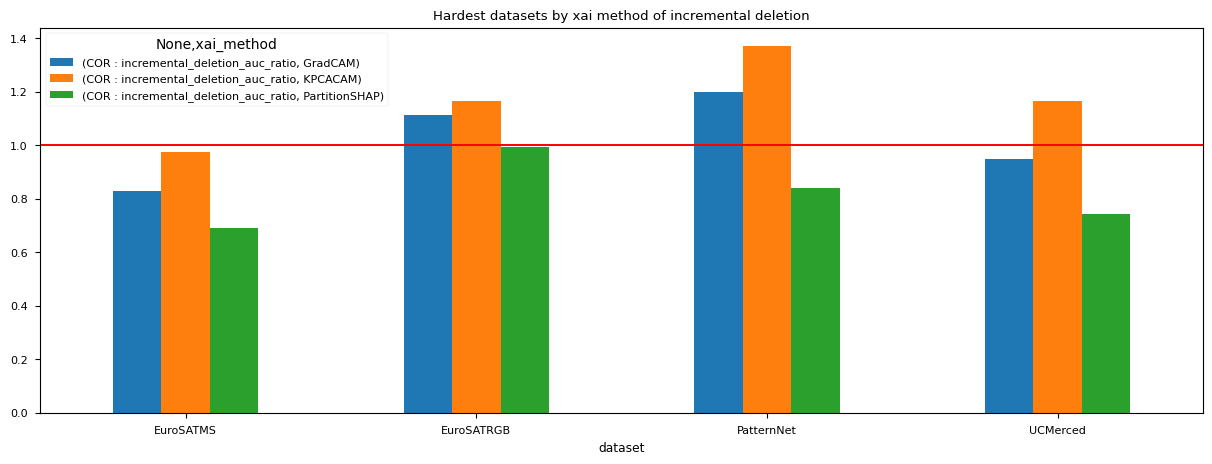

In [21]:
cor_id_df.reset_index(level=0).pivot(columns="xai_method").groupby(["dataset"]).mean().plot(kind="bar", rot=0, figsize=(15, 5), title="Hardest datasets by xai method of incremental deletion")
plt.axhline(1, color="r")

PatternNet was the hardest for GradCAM and KPCACAM with only PartitionSHAP getting sub 1 across all datasets.

In [52]:
cor_id_df.groupby(["xai_method", "dataset"]).describe()

COR : incremental_deletion_auc_ratio                                                               
                                                        count     mean      std      min      25%      50%      75%      max
xai_method    dataset                                                                                                       
GradCAM       EuroSATMS                  30.0                  0.82994  0.17327  0.45930  0.70656  0.89276  0.96929  1.06780
              EuroSATRGB                 30.0                  1.11285  0.60779  0.28518  0.81591  0.99190  1.33768  3.44704
              PatternNet                114.0                  1.19767  0.81778  0.36703  0.69203  0.89959  1.45060  5.98357
              UCMerced                   63.0                  0.94859  0.43346  0.33335  0.66329  0.84833  1.06849  2.45857
KPCACAM       EuroSATMS                  30.0                  0.97277  0.09761  0.74759  0.94474  0.99080  1.00468  1.19147
              EuroSATRGB                 30.0                  1.16655  0.57141  0.30470  0.90431  1.00399  1.34805  3.33477
              PatternNet                114.0                  1.36977  0.92951  0.36664  0.83759  0.98808  1.52479  6.35402
              UCMerced                   63.0                  1.16656  0.61853  0.33906  0.82170  0.98476  1.28504  3.30575
PartitionSHAP EuroSATMS                  30.0                  0.68926  0.23960  0.21928  0.52181  0.70970  0.91071  0.99972
              EuroSATRGB                 30.0                  0.99250  0.44885  0.26239  0.63781  0.95733  1.19169  2.02407
              PatternNet                114.0                  0.83876  0.33836  0.25907  0.58642  0.79110  1.02910  2.51742
              UCMerced                   63.0                  0.74126  0.26929  0.29997  0.55163  0.72084  0.95354  1.36409

All methods seem better than random for EuroSATMS deletion. PatternNet is hard for GradCAM and KPCACAM.

## Or good for any models?

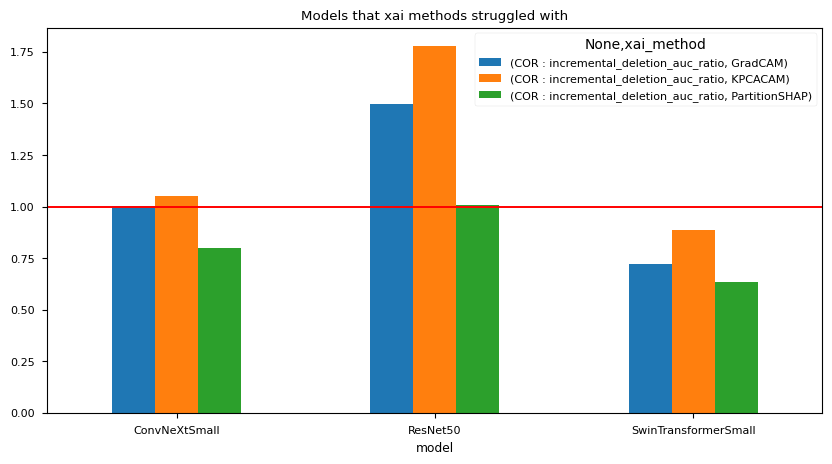

In [20]:
cor_id_df.reset_index(level=0).pivot(columns="xai_method").groupby(["model"]).mean().plot(kind="bar", rot=0, figsize=(10, 5), title="Models that xai methods struggled with")
plt.axhline(1, color="r")

In [54]:
cor_id_df.groupby(["xai_method", "model"]).describe()

COR : incremental_deletion_auc_ratio                                                               
                                                                  count     mean      std      min      25%      50%      75%      max
xai_method    model                                                                                                                   
GradCAM       ConvNeXtSmall                        79.0                  1.00323  0.67785  0.33335  0.68258  0.93757  1.07644  5.98357
              ResNet50                             79.0                  1.49967  0.71879  0.36703  0.93292  1.41777  1.85434  3.58557
              SwinTransformerSmall                 79.0                  0.71962  0.18251  0.28518  0.57146  0.70991  0.85114  1.02511
KPCACAM       ConvNeXtSmall                        79.0                  1.05277  0.71095  0.33906  0.76556  0.98005  1.16459  6.35402
              ResNet50                             79.0                  1.77783  0.86767  0.38608  1.01619  1.60475  2.44378  4.07367
              SwinTransformerSmall                 79.0                  0.88873  0.16578  0.30470  0.83230  0.92686  0.98800  1.25877
PartitionSHAP ConvNeXtSmall                        79.0                  0.80129  0.33443  0.21928  0.58900  0.75182  0.98680  1.90917
              ResNet50                             79.0                  1.00639  0.34377  0.49901  0.77030  0.98186  1.22673  2.51742
              SwinTransformerSmall                 79.0                  0.63245  0.20518  0.24977  0.50383  0.59518  0.77912  1.01339

All are actually worst for ResNet with the highest mean and std (can also be seen in graph above)?? Especially for GradCAM and KPCACAM.
And consistently (low std) best on the SwinTransformer with by far the least bad worst case.

## Overall reliability

In [55]:
cor_id_df.groupby("xai_method").describe()

COR : incremental_deletion_auc_ratio                                                               
                                             count     mean      std      min      25%      50%      75%      max
xai_method                                                                                                       
GradCAM                      237.0                  1.07417  0.66182  0.28518  0.68965  0.89988  1.21619  5.98357
KPCACAM                      237.0                  1.23978  0.75818  0.30470  0.84281  0.99002  1.34524  6.35402
PartitionSHAP                237.0                  0.81338  0.33677  0.21928  0.56973  0.76061  0.99408  2.51742

PartitionSHAP is the most reliable with a sub 1 incremental deletion ratio and lowest std. The UQ (75%) is also < 1.

In [56]:
cor_id_df[cor_id_df>=1].groupby("xai_method").count() / len(cor_id_df.loc["PartitionSHAP"])

,COR : incremental_deletion_auc_ratio
xai_method,
GradCAM,0.34177
KPCACAM,0.45148
PartitionSHAP,0.22785


KPCACAM is only slightly better than random overall at identifying important pixels.

# Output-Completeness (deletion_check_conf_drop & preservation_check_conf_drop)

We want this to be high with the best score being 1. Worst possible in both cases is -1.

In [30]:
oc_dp_cols = xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.contains("O-C")]
oc_dp_df: pd.DataFrame = xai_ds_m_c_df[oc_dp_cols].rename(columns={"O-C : deletion_check_conf_drop": "Del", "O-C : preservation_check_conf_drop": "Pres"})
oc_dp_df.columns

Index(['Del', 'Pres'], dtype='object')

GradCAM          Axes(0.1,0.15;0....
KPCACAM          Axes(0.382353,0....
PartitionSHAP    Axes(0.664706,0....
dtype: object

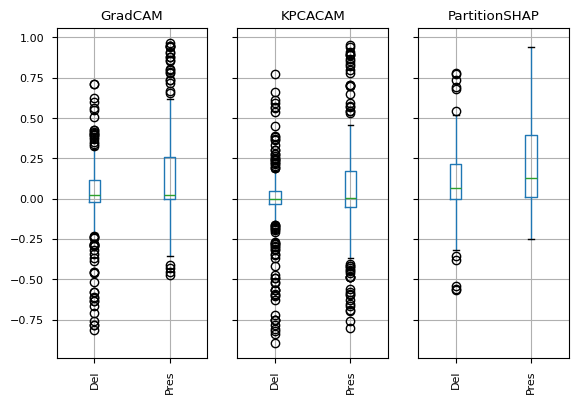

In [31]:
oc_dp_df.groupby("xai_method").boxplot(rot=90, subplots=True, layout=(1, 3))

On average, all are bad with a lot of variability. PartitionSHAP is slightly better.

Text(0.5, 0.98, 'Hard classes for all explainers on all models')

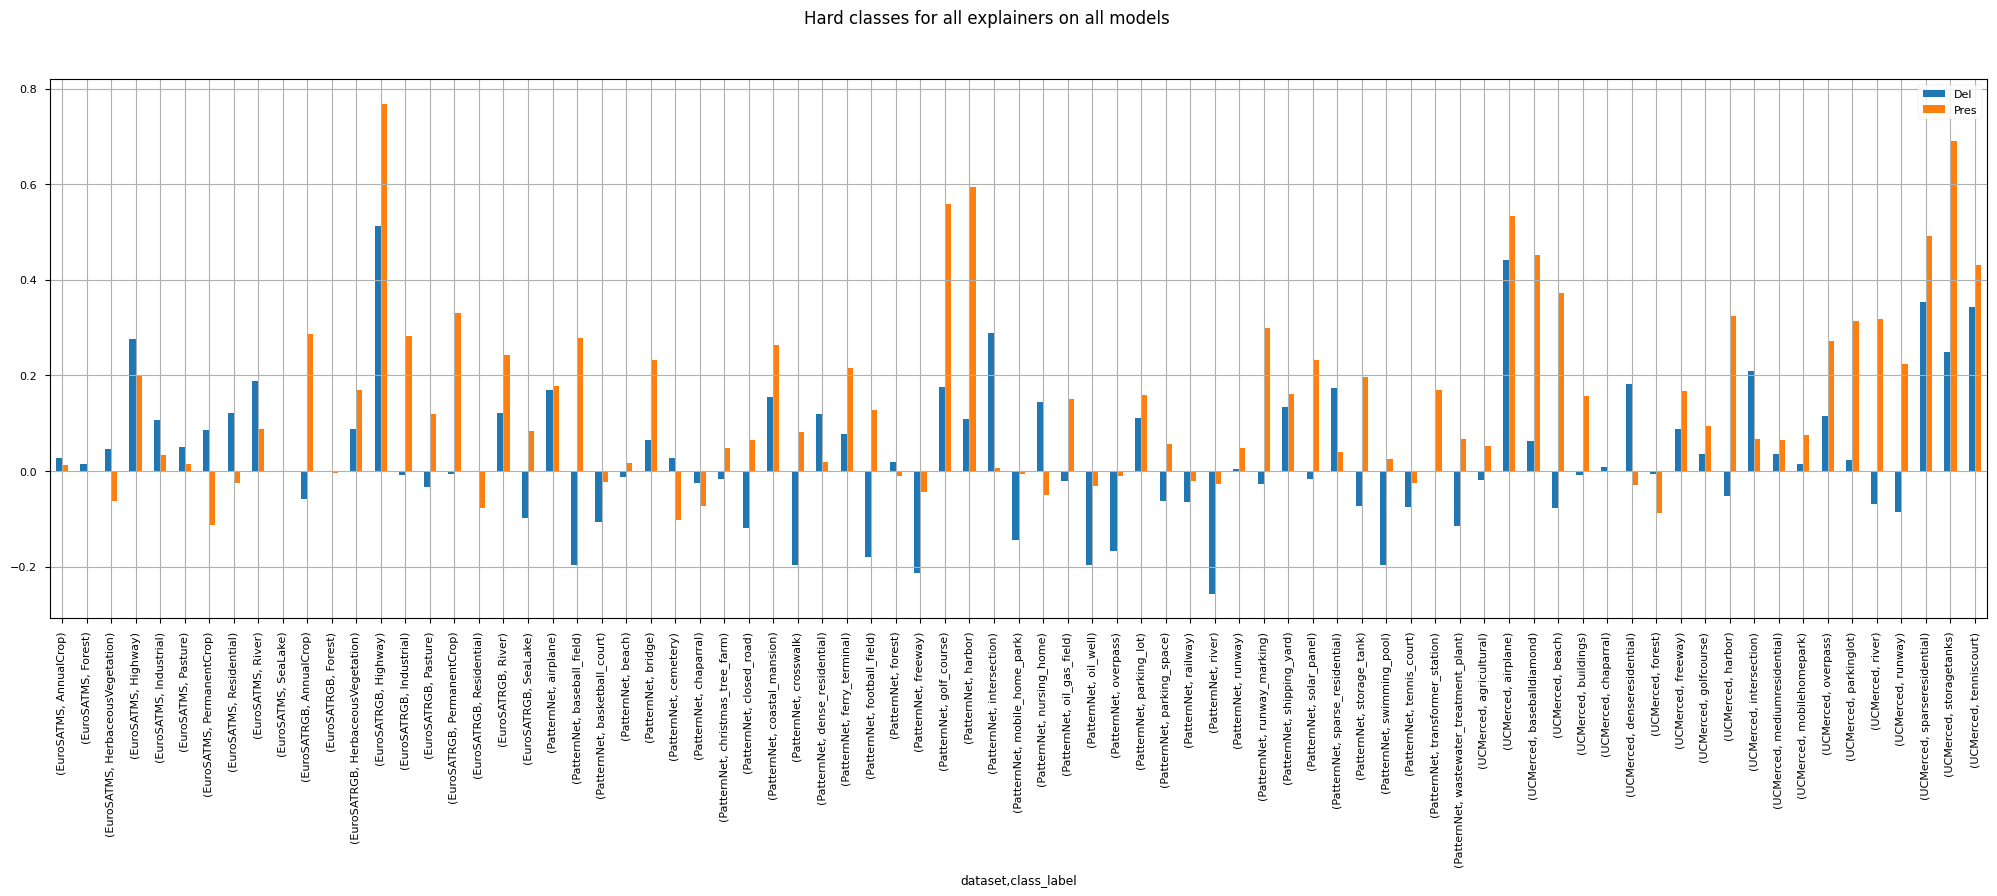

In [59]:
oc_dp_df_by_class_mean = oc_dp_df.groupby(["dataset", "class_label"]).mean()
oc_dp_df_by_class_mean.plot(kind="bar", rot=90, figsize=(25, 7), grid=True, subplots=False)
plt.suptitle("Hard classes for all explainers on all models")

The easiest classes across the datasets to delete pixels from are EuroSAT-highway, PatternNet-intersection, UCM-airplane, sparse residential, storage tanks, and tennis court.
Perhaps because these are scenes where objects are localised to specific areas where important pixels can be easily deleted. In other classes, nearest neighbour in filling might result in such similar colours that the model still believes them to be present.
PatternNet's freeway, baseball field (this class is easier to preserve) and river classes are very hard to delete though.

For preserving pixels, EuroSAT-highway remains easy, PatternNet-golf course and harbour, UCM-airplane, baseball diamond, beach, sparse residential, storage tanks and tennis court.
Since the surroundings are important for these as well, we theorise that classes can more easily change if these surrounding pixels are deleted.

## Investigate performance class by class for each explainer

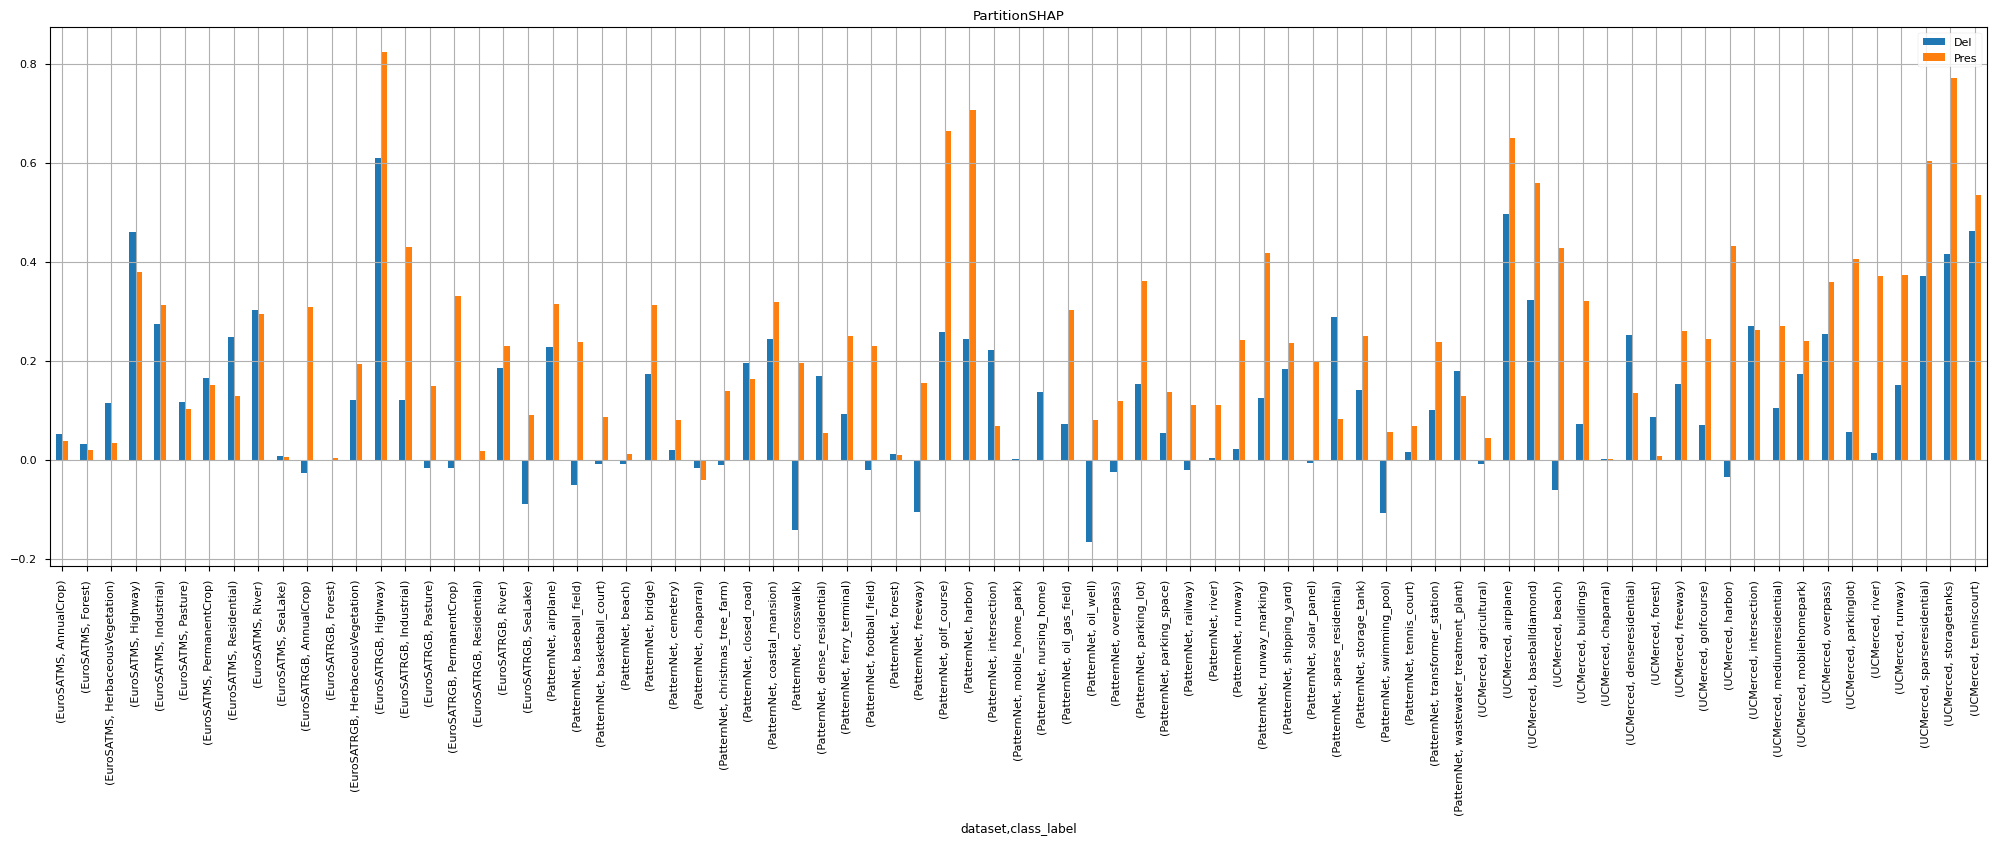

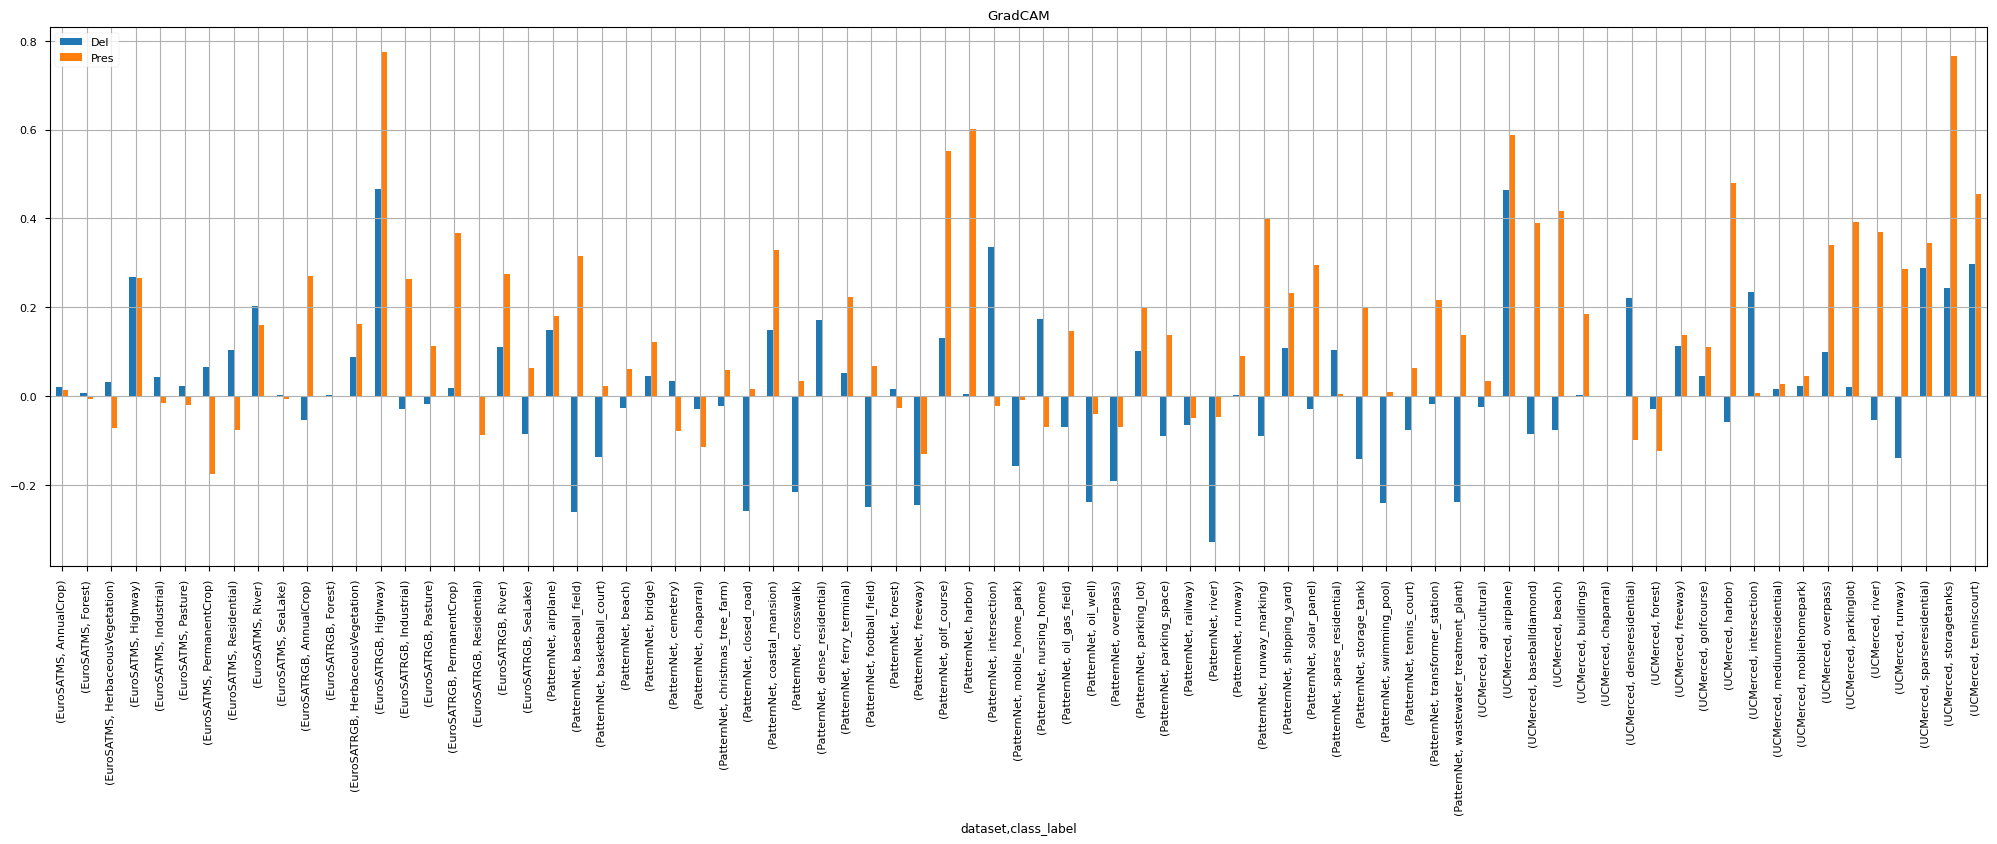

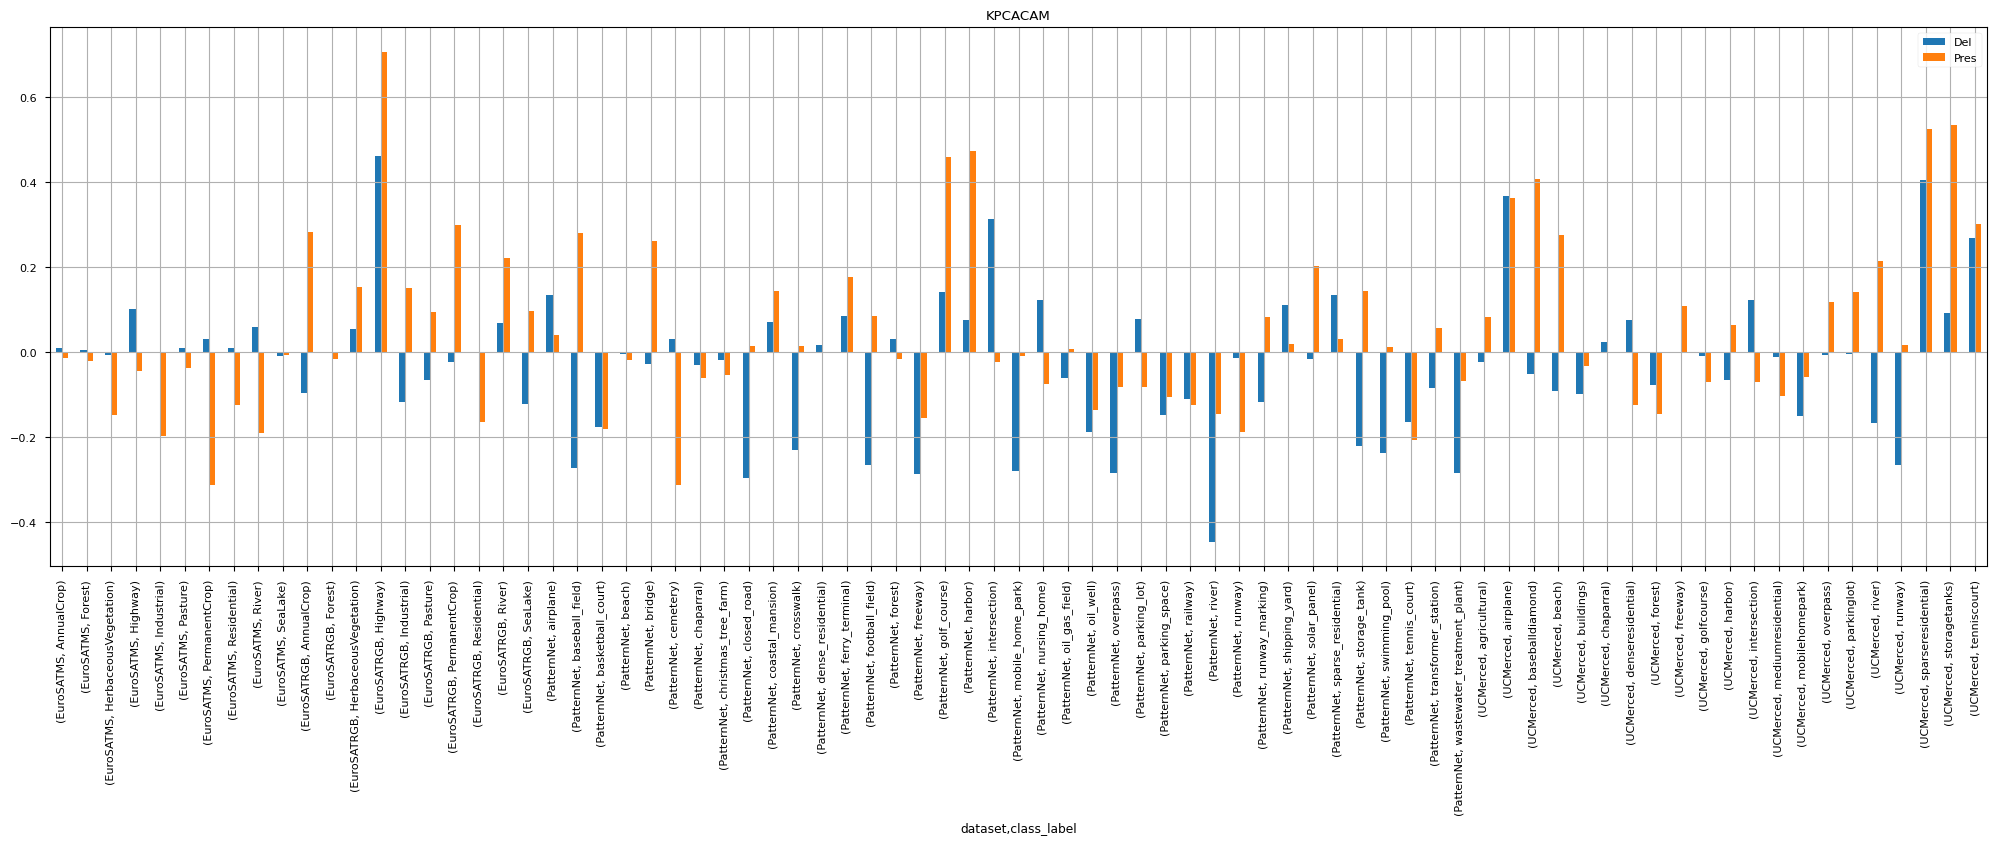

In [60]:
for e_name in t.get_args(xai.EXPLAINER_NAMES):
    oc_dp_df.loc[e_name].groupby(["dataset", "class_label"]).mean().plot(kind="bar", rot=90, figsize=(25, 7), grid=True, subplots=False, title=e_name)
    plt.show()

PartitionSHAP manages a positive score across almost all classes.

Text(0.5, 0.98, 'KPCACAM - average')

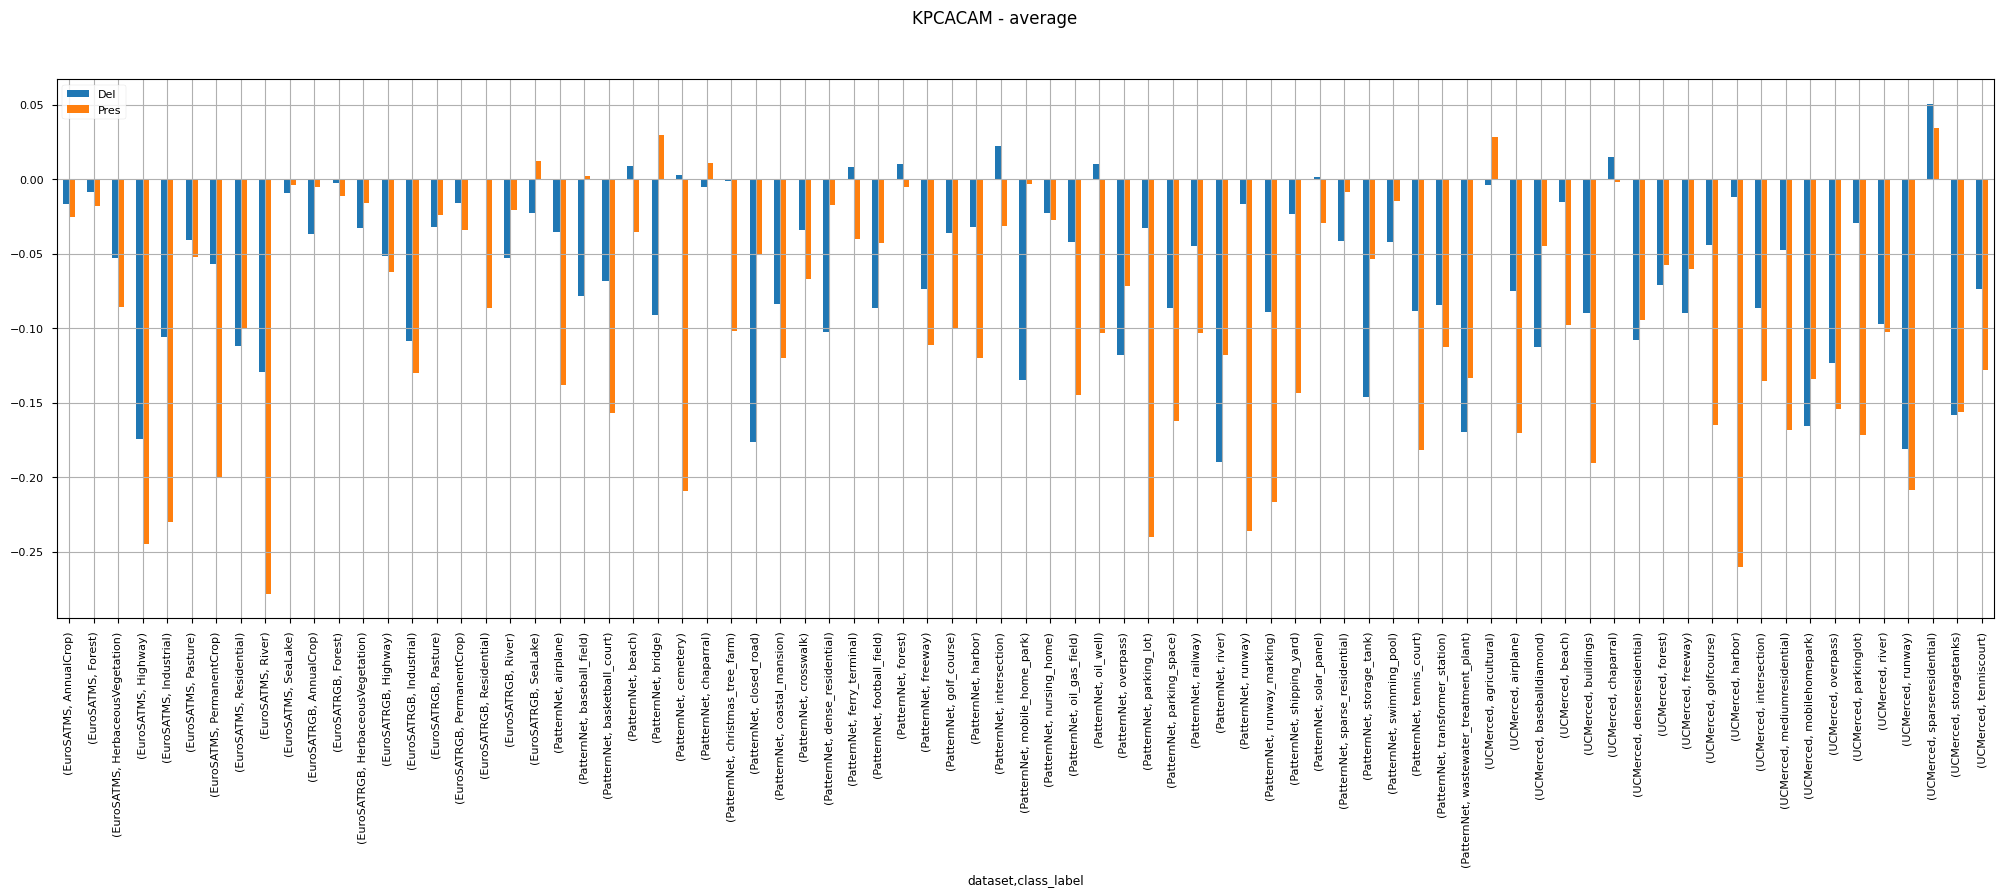

In [61]:
(oc_dp_df.loc["KPCACAM"].groupby(["dataset", "class_label"]).mean() - oc_dp_df_by_class_mean).plot(kind="bar", rot=90, figsize=(25, 7), grid=True, subplots=False)
plt.suptitle("KPCACAM - average")

KPCACAM is worse than average in virtually every class for both metrics.

## Explainer efficacy on different models

Text(0.5, 0.98, 'Model robustness')

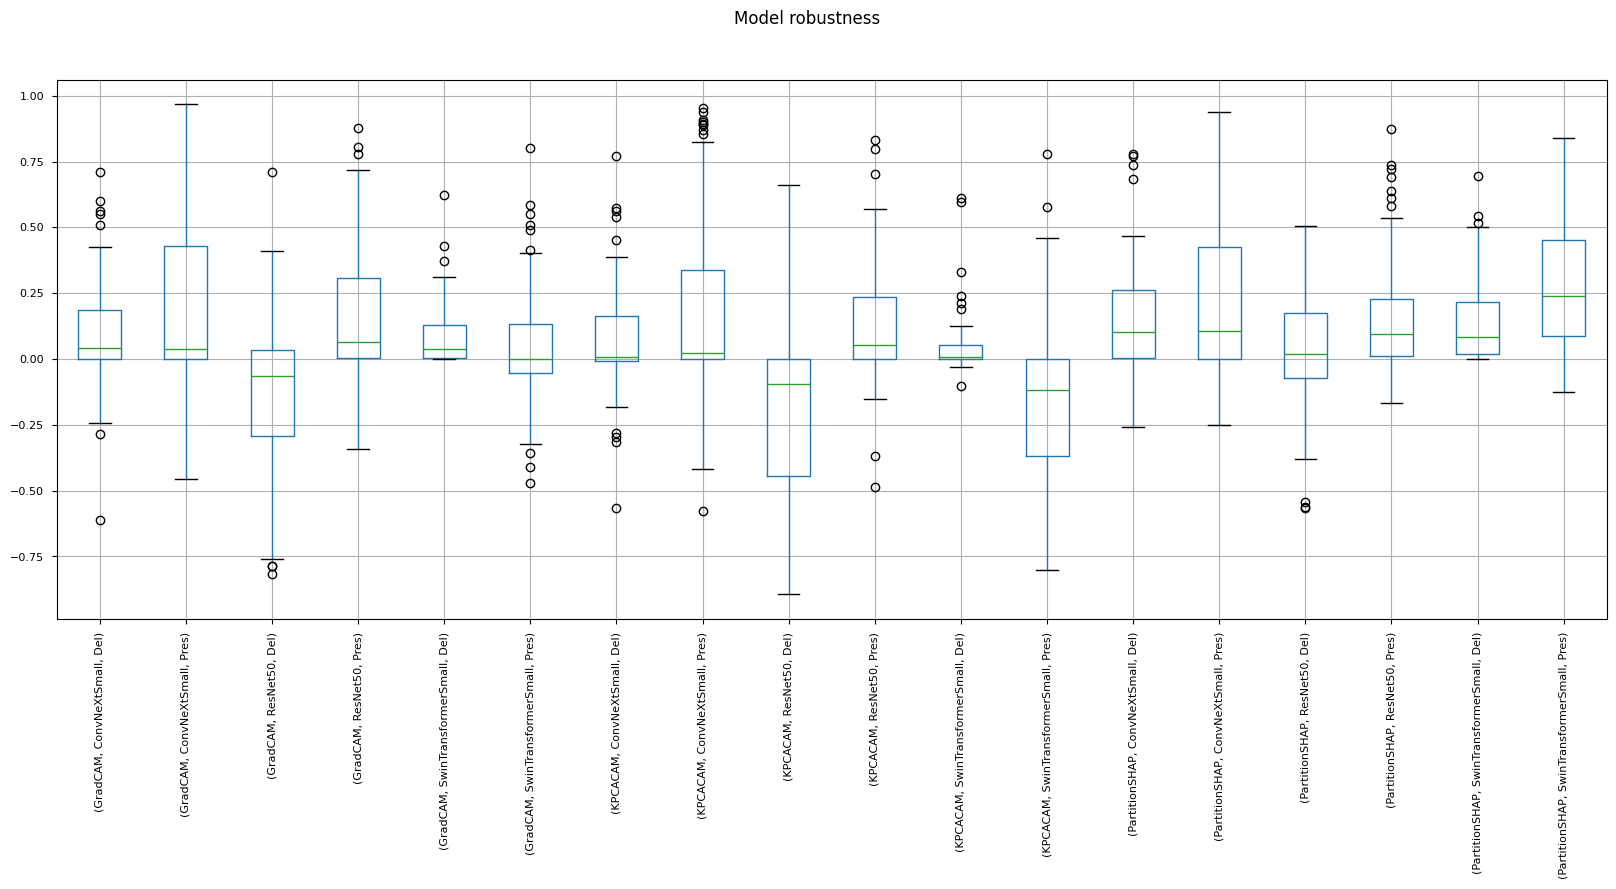

In [62]:
oc_dp_df.groupby(["xai_method", "model"]).boxplot(rot=90, figsize=(20, 7), subplots=False)
plt.suptitle("Model robustness")

Deleting pixels rarely flipped ResNets.

In [63]:
oc_dp_df.groupby(["xai_method", "model"]).describe()

Del                                                                     Pres                                                                           
                                   count     mean      std      min          25%      50%      75%      max count     mean      std      min          25%          50%          75%      max
xai_method    model                                                                                                                                                                         
GradCAM       ConvNeXtSmall         79.0  0.09813  0.21005 -0.61278 -1.81212e-03  0.04269  0.18533  0.71167  79.0  0.22697  0.35397 -0.45732  3.62396e-05  3.66099e-02  4.29130e-01  0.96664
              ResNet50              79.0 -0.14403  0.29999 -0.81754 -2.90927e-01 -0.06387  0.03403  0.71002  79.0  0.16682  0.23844 -0.34340  5.57780e-03  6.36860e-02  3.06990e-01  0.87618
              SwinTransformerSmall  79.0  0.08381  0.11208 -0.00014  4.17697e-03  0.03764  0.12839  0.62235  79.0  0.04113  0.22976 -0.47041 -5.46895e-02 -4.17233e-06  1.31207e-01  0.80123
KPCACAM       ConvNeXtSmall         79.0  0.07359  0.20592 -0.56534 -7.66703e-03  0.00837  0.16274  0.77114  79.0  0.18528  0.33876 -0.57787  5.96046e-08  2.11669e-02  3.36318e-01  0.95191
              ResNet50              79.0 -0.20597  0.31352 -0.89428 -4.45328e-01 -0.09306 -0.00026  0.66023  79.0  0.13046  0.22553 -0.48505  1.55628e-04  5.35928e-02  2.36628e-01  0.83364
              SwinTransformerSmall  79.0  0.04726  0.10997 -0.10365  1.08033e-07  0.00886  0.05168  0.61063  79.0 -0.17442  0.30012 -0.80272 -3.66612e-01 -1.17630e-01  3.03984e-06  0.77843
PartitionSHAP ConvNeXtSmall         79.0  0.16419  0.20519 -0.25849  3.46779e-03  0.10417  0.26383  0.77958  79.0  0.25389  0.31882 -0.24879  1.88887e-04  1.05637e-01  4.26490e-01  0.93796
              ResNet50              79.0  0.02958  0.21782 -0.56401 -7.08983e-02  0.01746  0.17627  0.50657  79.0  0.16312  0.21738 -0.16676  1.13874e-02  9.43065e-02  2.28054e-01  0.87185
              SwinTransformerSmall  79.0  0.14386  0.15928 -0.00013  1.73575e-02  0.08446  0.21570  0.69325  79.0  0.28084  0.23796 -0.12596  8.80092e-02  2.37946e-01  4.52898e-01  0.83980

ResNet explanations are very difficult to delete from. SwinTransformer is hard to preserve for CAM methods. ConvNeXt somewhat explainable by all and for specific classes can do very well.

### For specific datasets

<Axes: xlabel='xai_method,class_label'>

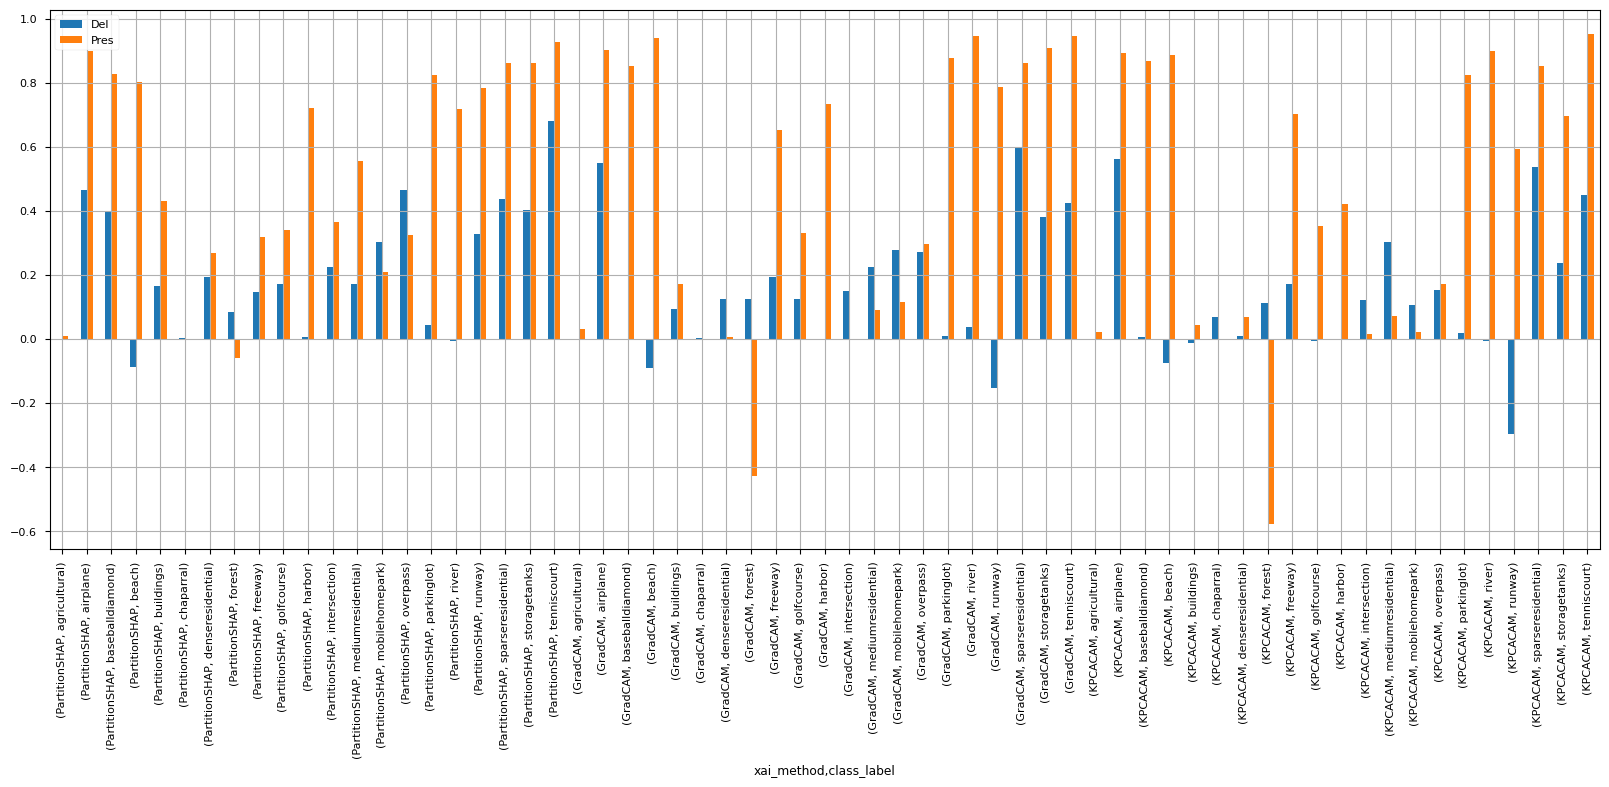

In [64]:
oc_dp_df.loc[:, "UCMerced", "ConvNeXtSmall"].plot(kind="bar", rot=90, figsize=(20, 7), subplots=False, grid=True)

The same classes are consistently difficult across all explanation methods. For some specific classes, all methods are successful at identifying important (e.g. PatternNet tennis court)

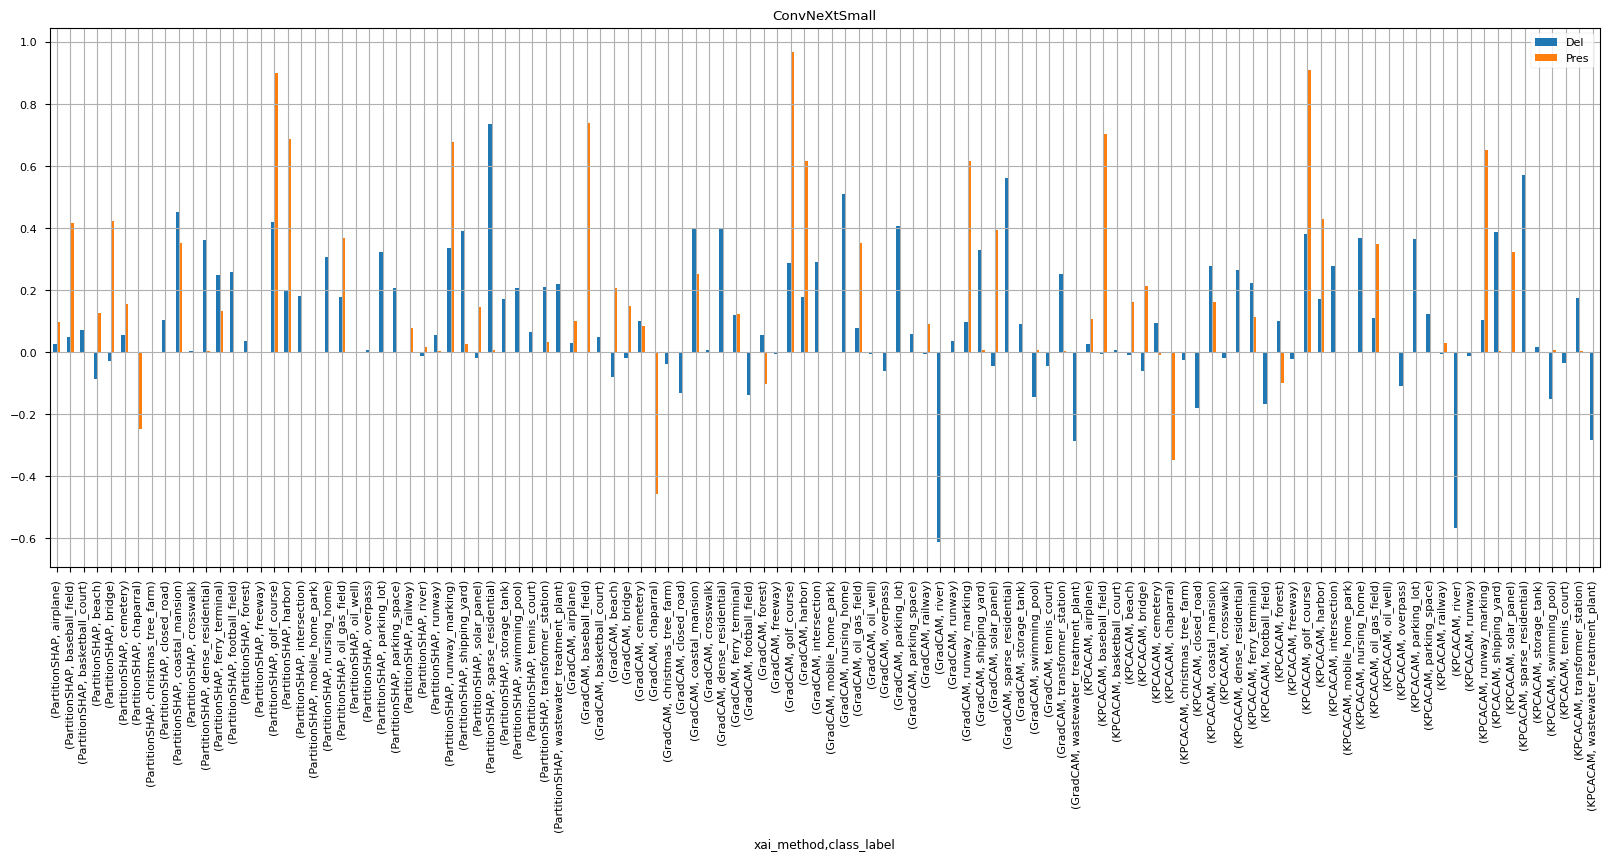

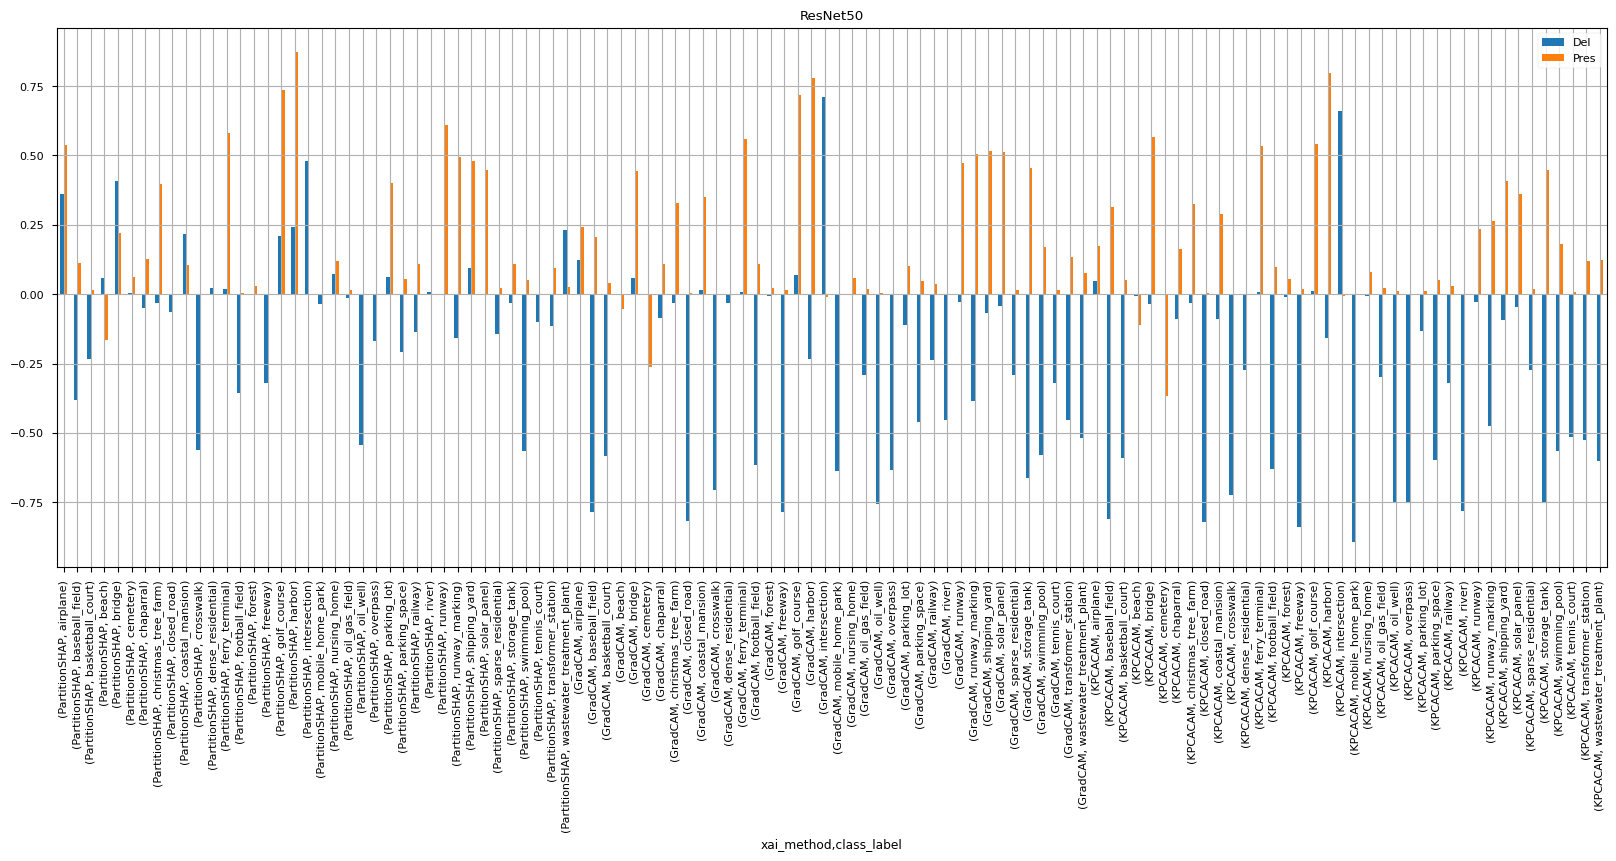

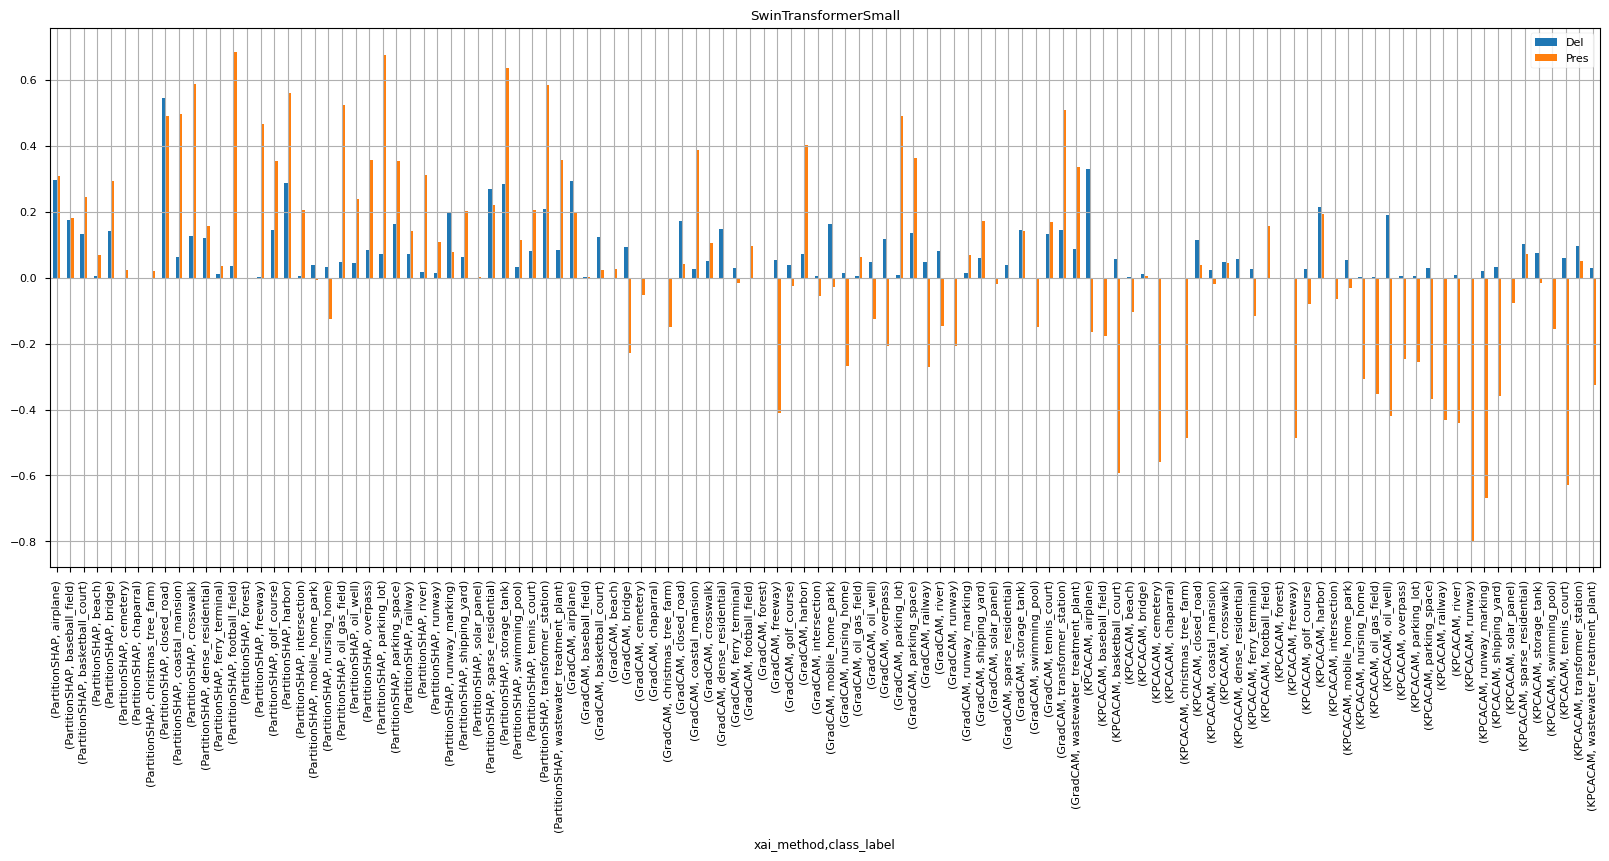

In [65]:
for m in AVAILABLE_MODELS:
    oc_dp_df.loc[:, "PatternNet", m].plot(kind="bar", rot=90, figsize=(20, 7), subplots=False, grid=True, title=m)
    plt.show()

For PatternNet, best explanations are for ConvNeXt across all explainers. KPCA struggles to preserve the correct areas for the SwinTransformer.

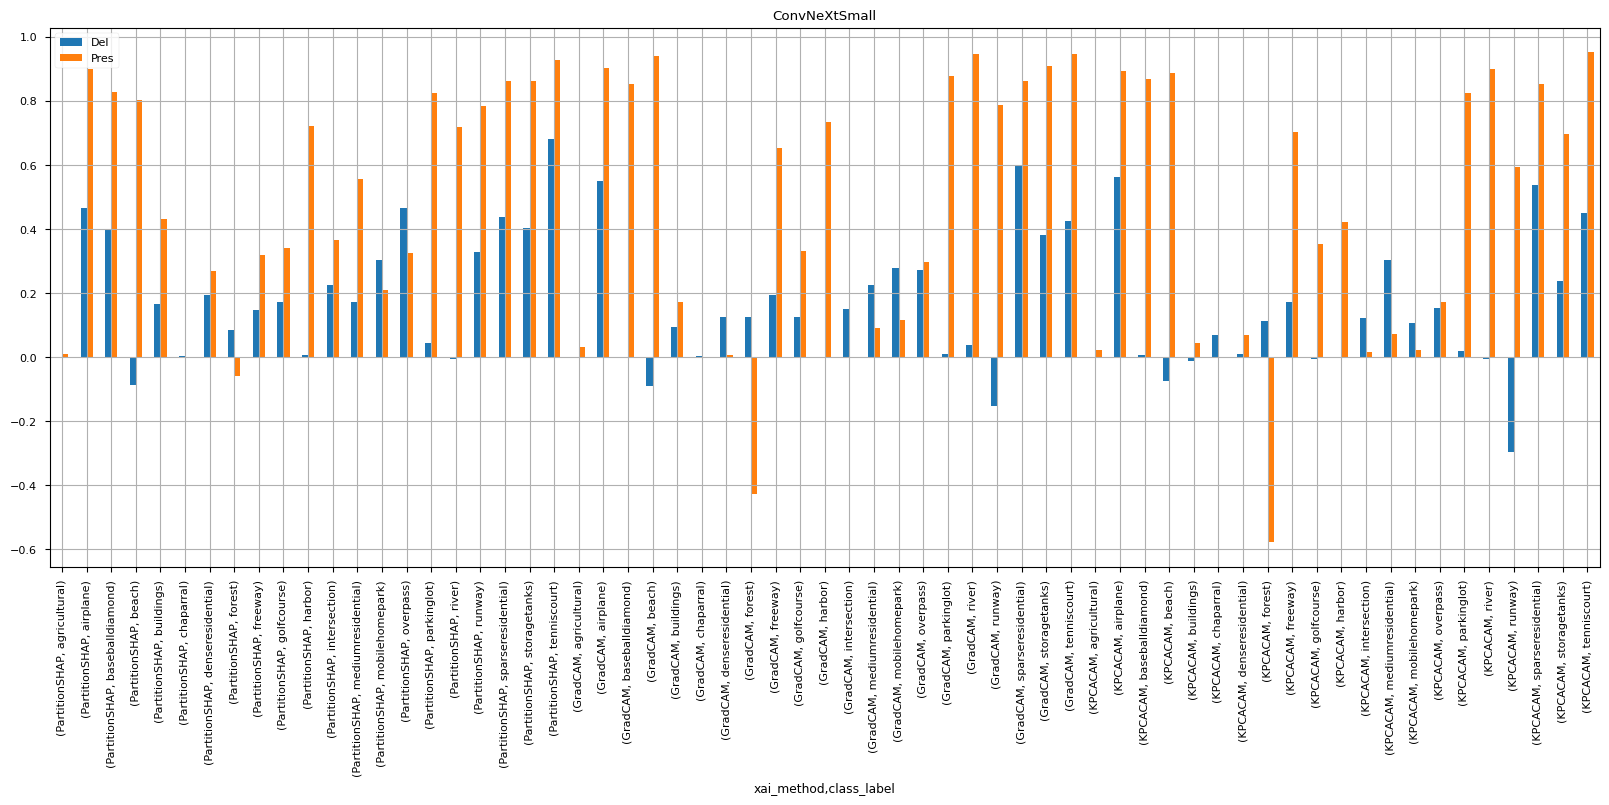

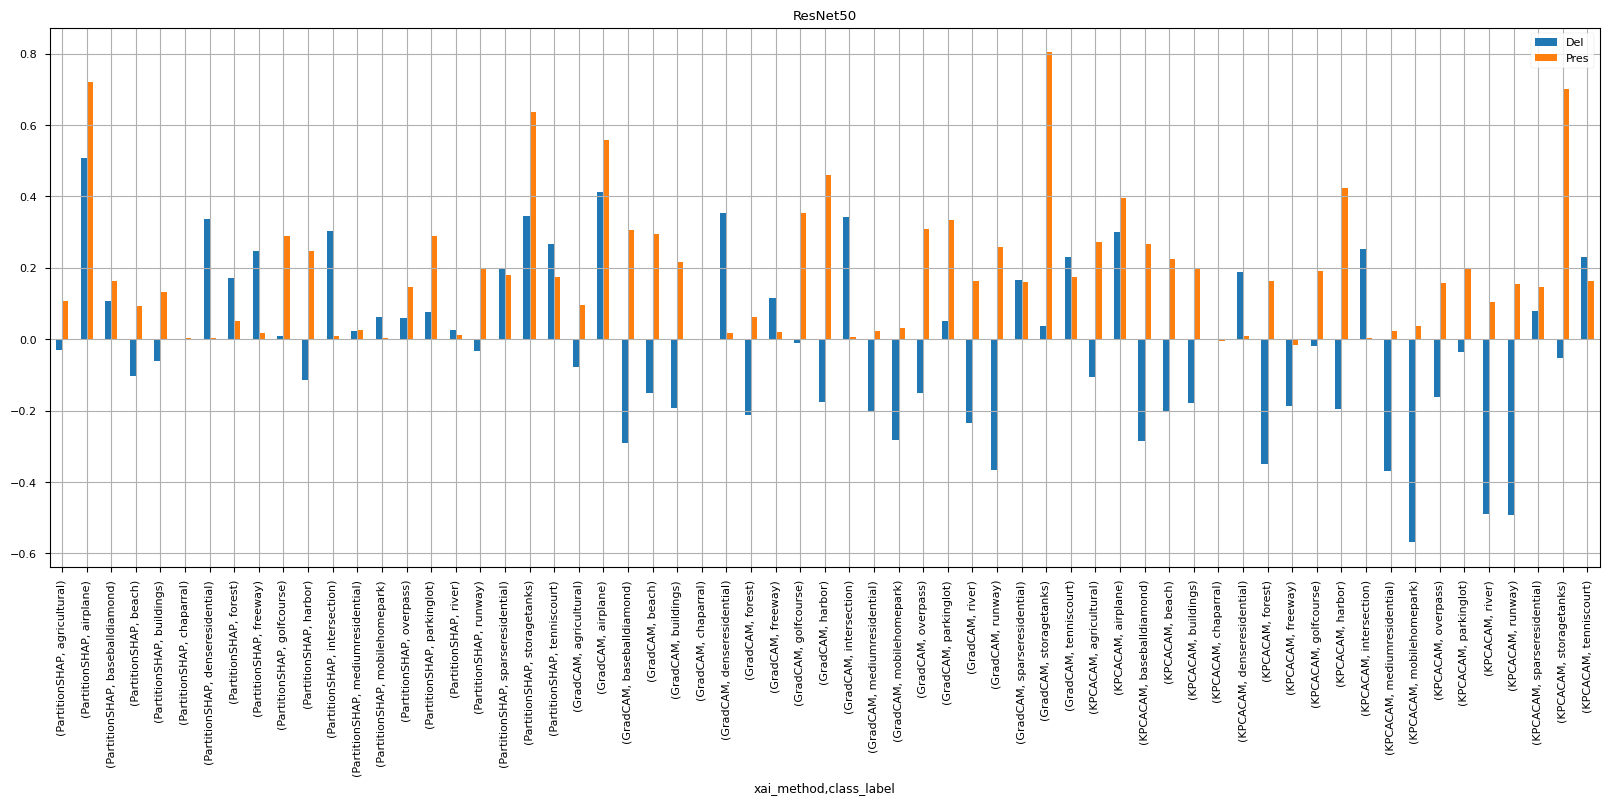

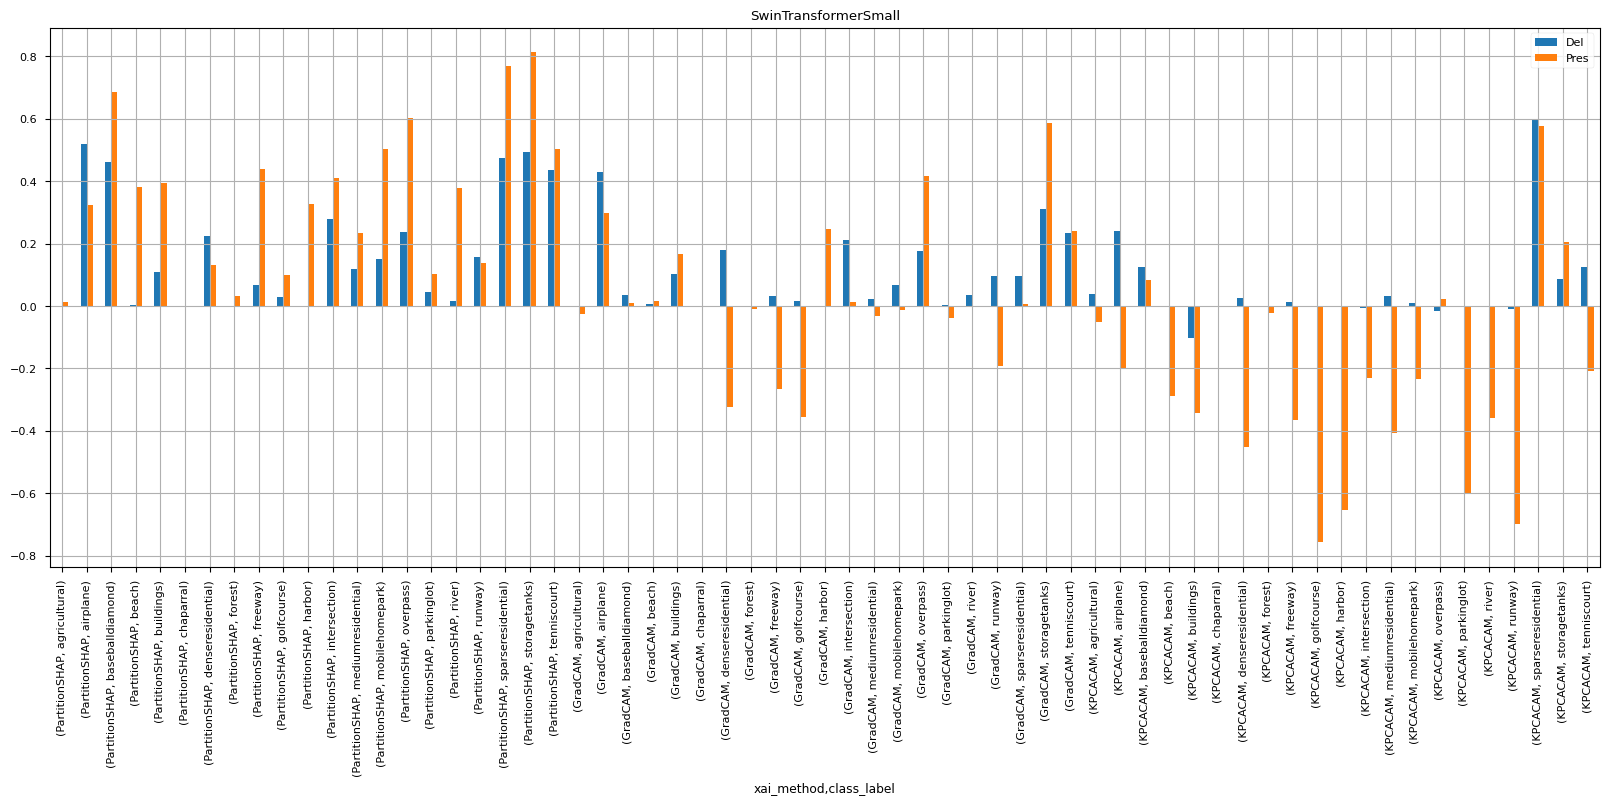

In [66]:
for m in AVAILABLE_MODELS:
    oc_dp_df.loc[:, "UCMerced", m].plot(kind="bar", rot=90, figsize=(20, 7), subplots=False, grid=True, title=m)
    plt.show()

For UCMerced again, ConvNeXt easiest to explain. CAM methods struggle to delete from ResNet (small convolutions make it sensitive to small regions changing?). KPCACAM can't preserve for SwinT (large attention based tokens mean it considers the whole image?)

# Contrastivity (adversarial_attack_similarity)

We want this to be low with the best score being 0. Worst case is +1. A negative spearman's rank means the opposite pixels are relevant which is kind of what we expect for an adversarial attack.

In [67]:
con_cols = xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.contains("CON")]
con_df: pd.DataFrame = xai_ds_m_c_df[con_cols].copy()
con_df.columns

Index(['CON : adv_attk_sim : SR', 'CON : adv_attk_sim : top_m', 'CON : adv_attk_sim : ssim'], dtype='object')

### Examine and remove lots of N/A instances

In [68]:
print(con_df["CON : adv_attk_sim : SR"].loc["GradCAM"].isna().groupby(level=["model", "dataset"]).sum())

model                 dataset   
ConvNeXtSmall         EuroSATMS      1
                      EuroSATRGB     0
                      PatternNet    20
                      UCMerced      16
ResNet50              EuroSATMS      0
                      EuroSATRGB     0
                      PatternNet     0
                      UCMerced       0
SwinTransformerSmall  EuroSATMS      1
                      EuroSATRGB     0
                      PatternNet     2
                      UCMerced       4
Name: CON : adv_attk_sim : SR, dtype: int64


ConvNeXt on PatternNet couldn't generate adv examples on 20/38 classes.
On UCMerced, " on 16/21. Too robust to generate adversarial examples. Skip these two for evaluation.

In [69]:
con_df.drop(index=[(e, "PatternNet", "ConvNeXtSmall") for e in t.get_args(xai.EXPLAINER_NAMES)], inplace=True)
con_df.drop(index=[(e, "UCMerced", "ConvNeXtSmall") for e in t.get_args(xai.EXPLAINER_NAMES)], inplace=True)

In [70]:
print(con_df["CON : adv_attk_sim : SR"].loc["GradCAM"].isna().groupby(level=["model", "dataset"]).sum())

model                 dataset   
ConvNeXtSmall         EuroSATMS     1
                      EuroSATRGB    0
ResNet50              EuroSATMS     0
                      EuroSATRGB    0
                      PatternNet    0
                      UCMerced      0
SwinTransformerSmall  EuroSATMS     1
                      EuroSATRGB    0
                      PatternNet    2
                      UCMerced      4
Name: CON : adv_attk_sim : SR, dtype: int64


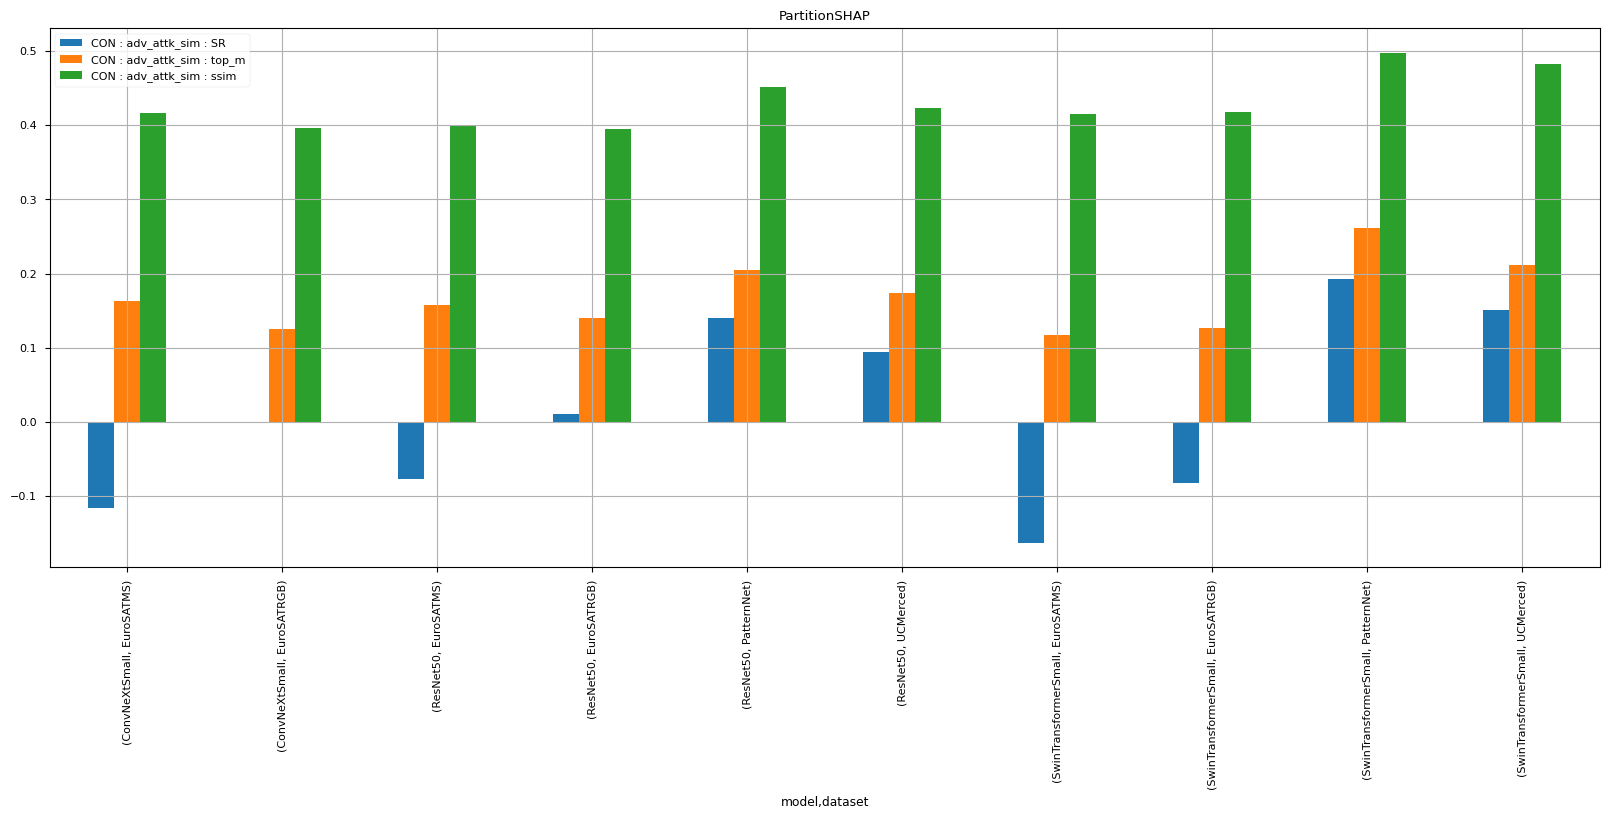

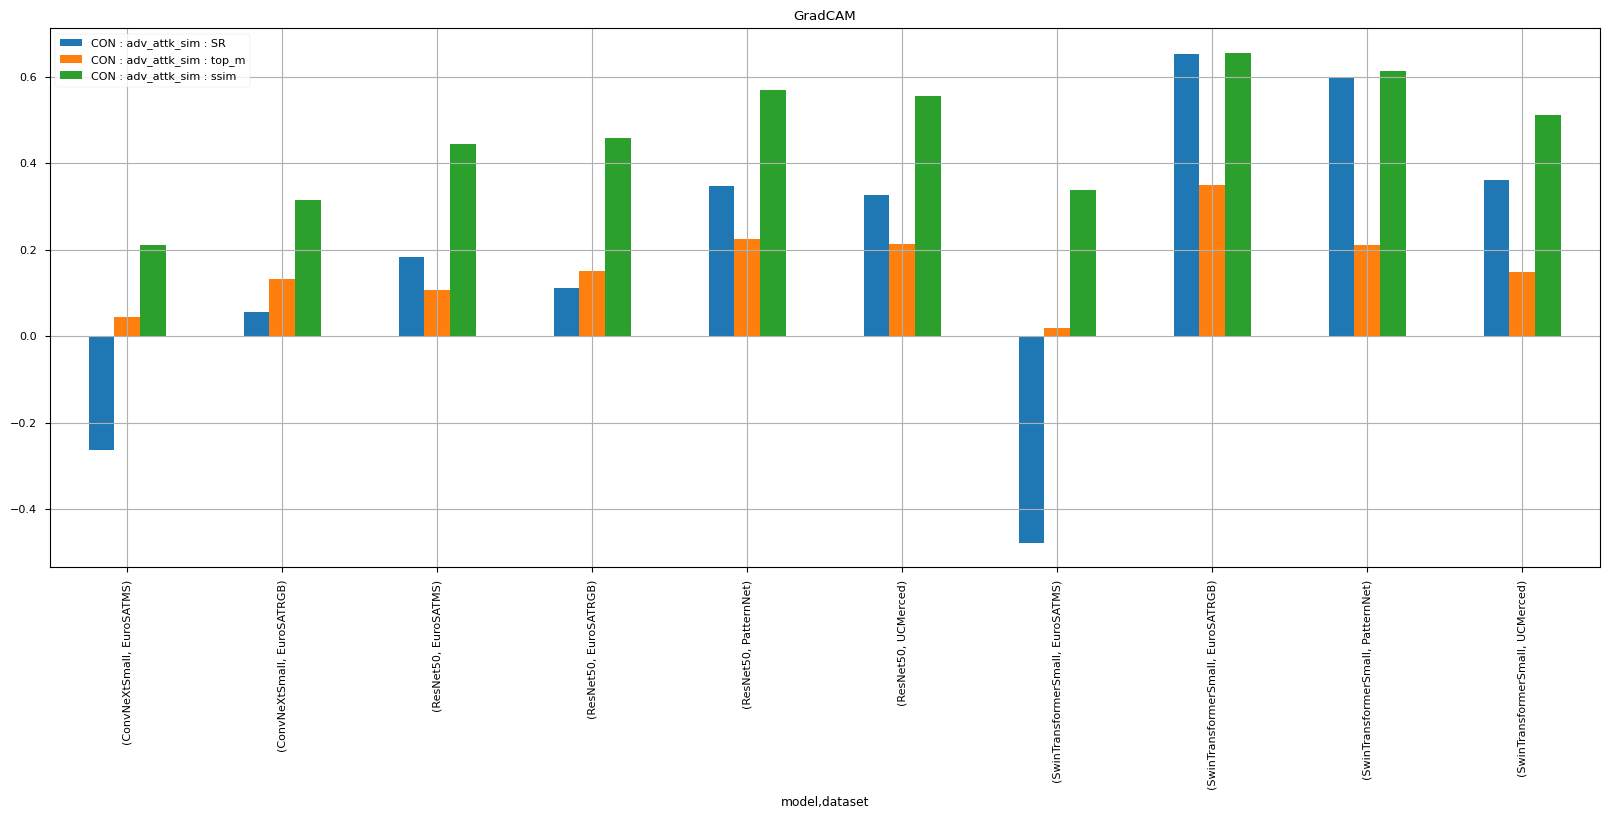

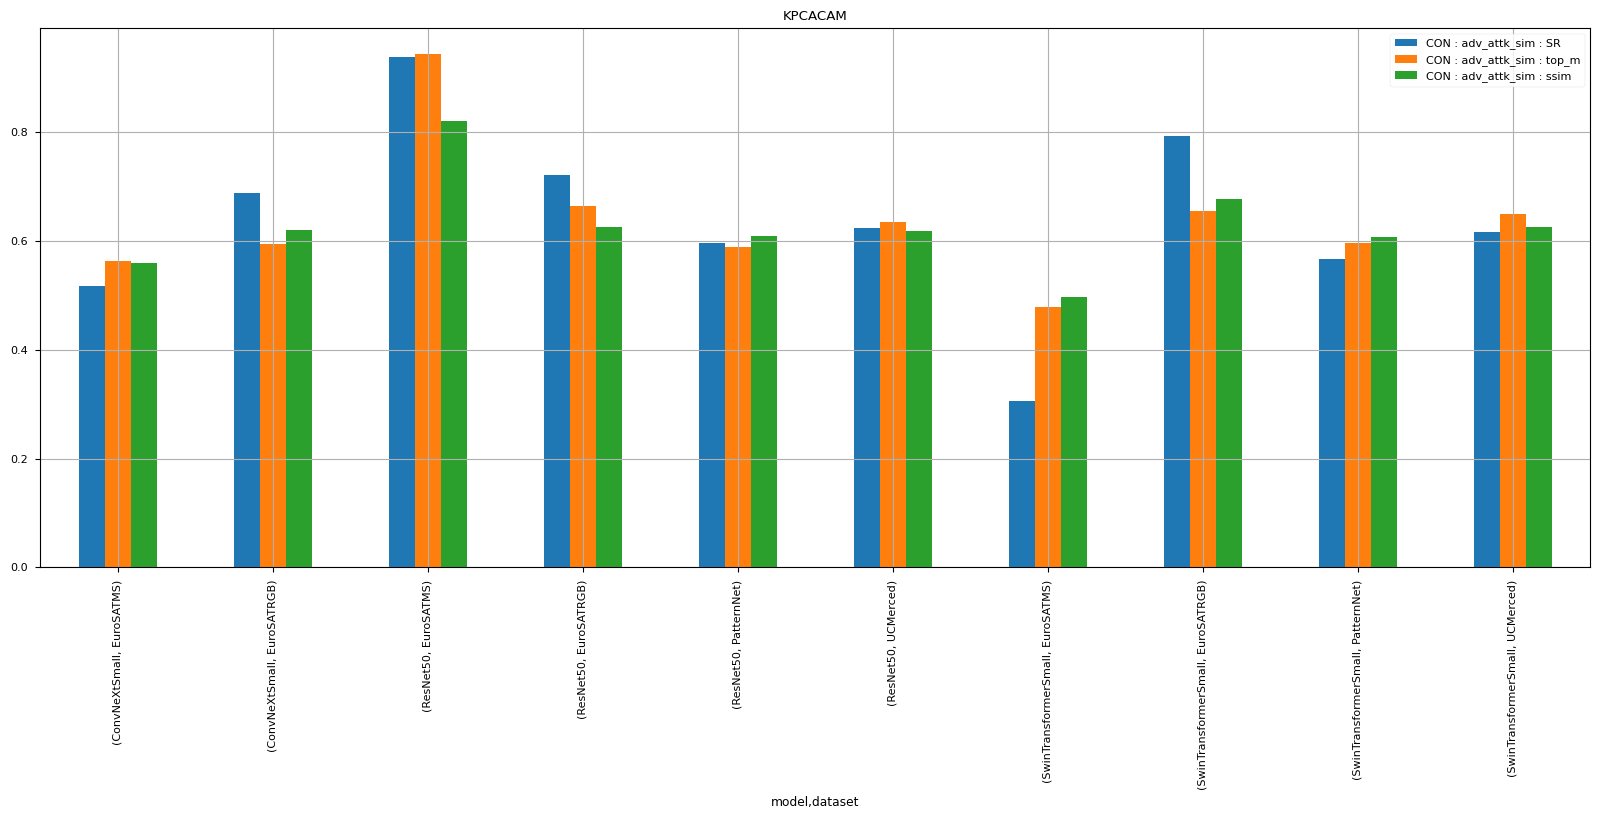

In [71]:
for e_name in t.get_args(xai.EXPLAINER_NAMES):
    con_df.loc[e_name].groupby(level=["model", "dataset"]).mean().plot(kind="bar", rot=90, figsize=(20, 7), subplots=False, grid=True, title=e_name)
    plt.show()

array([<Axes: title={'center': 'CON : adv_attk_sim : SR'}, xlabel='xai_method,model,dataset'>,
       <Axes: title={'center': 'CON : adv_attk_sim : top_m'}, xlabel='xai_method,model,dataset'>,
       <Axes: title={'center': 'CON : adv_attk_sim : ssim'}, xlabel='xai_method,model,dataset'>],
      dtype=object)

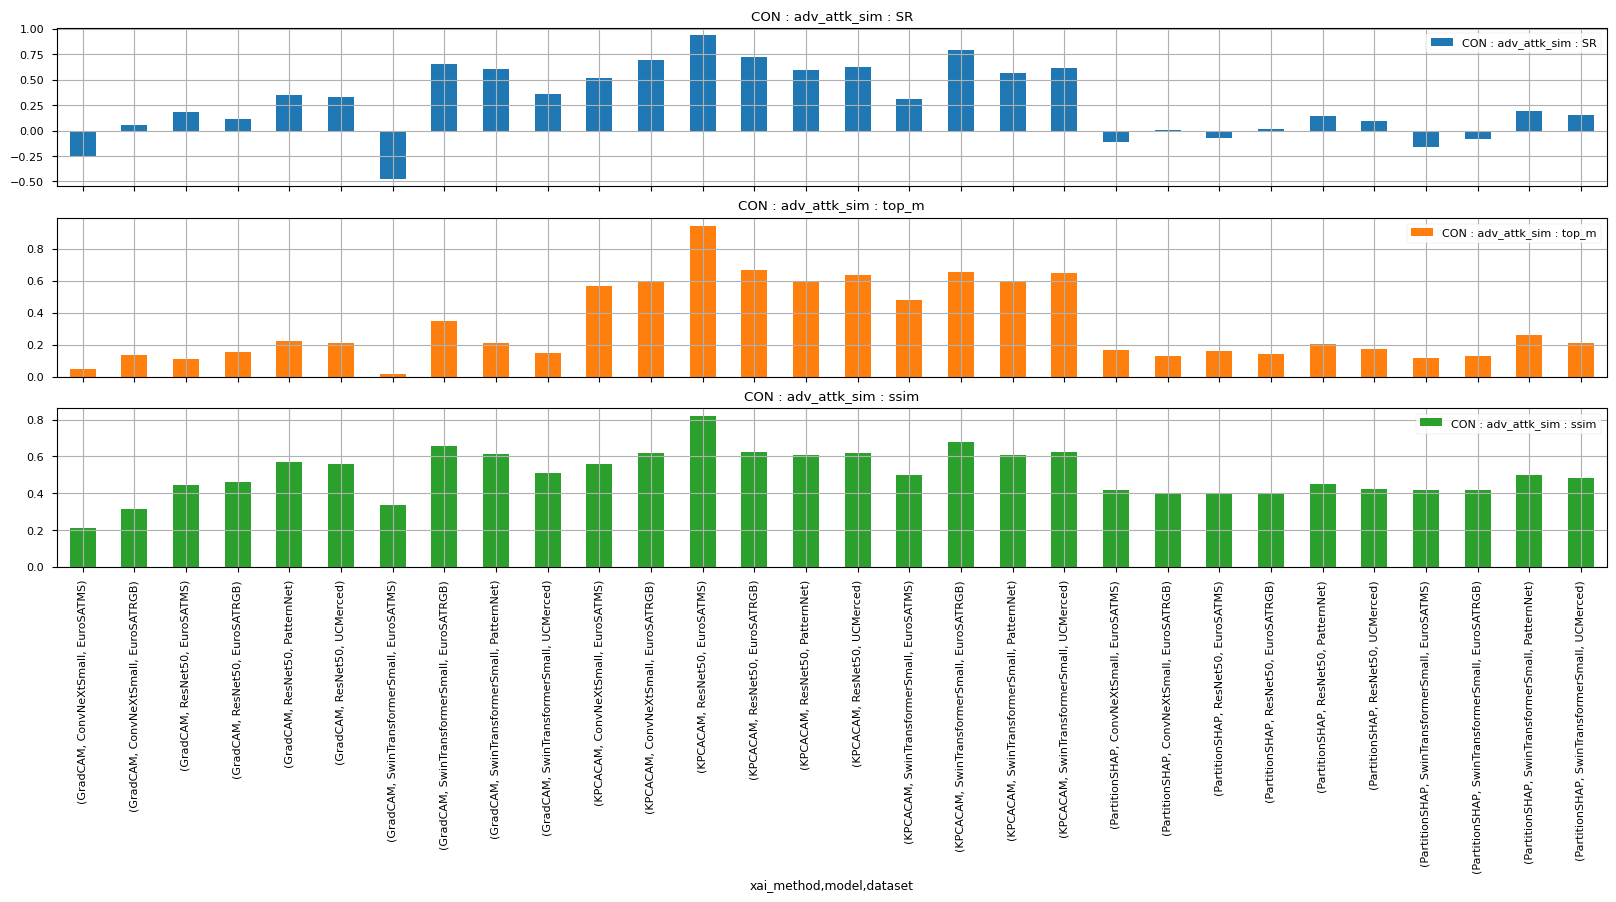

In [72]:
# Same chart as above but combined into one row
con_df.groupby(level=["xai_method", "model", "dataset"]).mean().plot(kind="bar", rot=90, figsize=(20, 7), subplots=True, grid=True)

KPCA show much higher similarity scores across all three metrics on all models and datasets. PartitionSHAP's explanations score higher on SSIM metrics (maybe because they are more targeted/sparse) but other metrics are lower as expected.
GradCAM struggles with SwinTransformer (except EuroSATMS) the most and is least contrastive for EuroSATRGB.

PartitionSHAP is very consistent across different models and datasets (as expected for a completely model agnostic method) - see stds below also. Overall, it does best across all metrics and datasets with GradCAM not far behind.

In [73]:
for col in con_df.columns:
    print("\n", col)
    print(con_df[col].groupby(level=["xai_method"]).describe())


 CON : adv_attk_sim : SR
               count     mean      std      min      25%      50%      75%      max
xai_method                                                                         
GradCAM        170.0  0.30082  0.32029 -0.59831  0.12608  0.35273  0.54576  0.83997
KPCACAM        170.0  0.61974  0.20782 -0.05544  0.48275  0.64736  0.76956  0.98511
PartitionSHAP  170.0  0.07524  0.16268 -0.46133 -0.02049  0.08642  0.18711  0.39888

 CON : adv_attk_sim : top_m
               count     mean      std      min      25%      50%      75%      max
xai_method                                                                         
GradCAM        170.0  0.18296  0.09902  0.00586  0.12006  0.17129  0.25899  0.47757
KPCACAM        170.0  0.62455  0.13736  0.29102  0.54496  0.62988  0.69356  0.97380
PartitionSHAP  170.0  0.19123  0.08406  0.05059  0.13032  0.17420  0.23846  0.49933

 CON : adv_attk_sim : ssim
               count     mean      std      min      25%      50%      75%   

## Comparing model performance

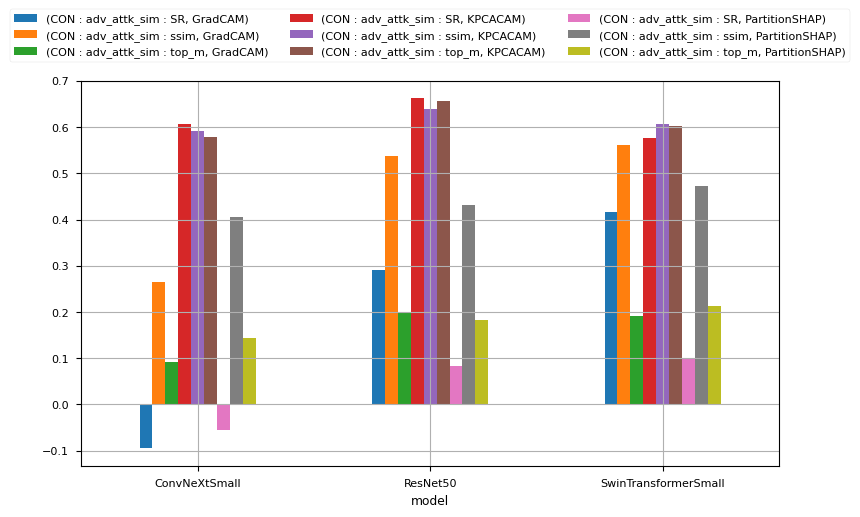

In [74]:
mean_by_model = con_df.reset_index(level=0).pivot(columns="xai_method").groupby(level=["model"]).mean()
mean_by_model.sort_index(axis=1, level=1).plot(kind="bar", grid=True, subplots=False, figsize=(9, 5), rot=0)
plt.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, 1.2))

For GradCAM and PartitionSHAP, difficulty goes (easiest) ConvNeXt -> ResNet -> SwinT (hardest).

For KPCA, (easiest) Conv -> SwinT -> ResNet (hardest)

## Similarity metrics by dataset

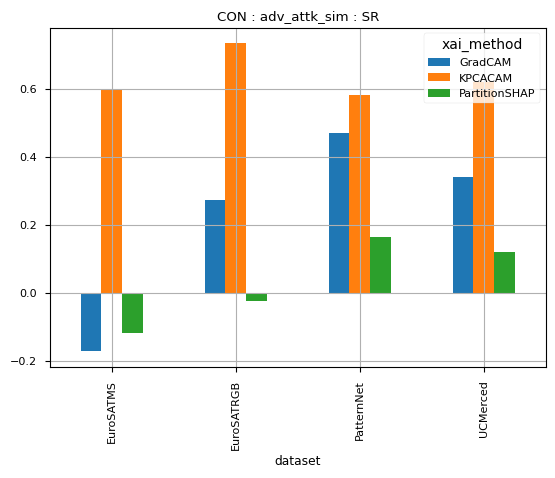

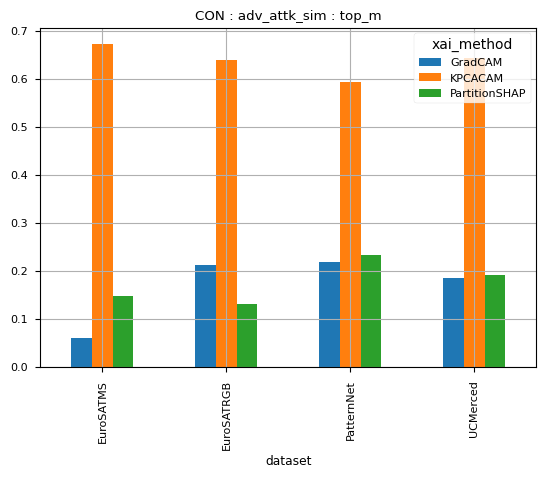

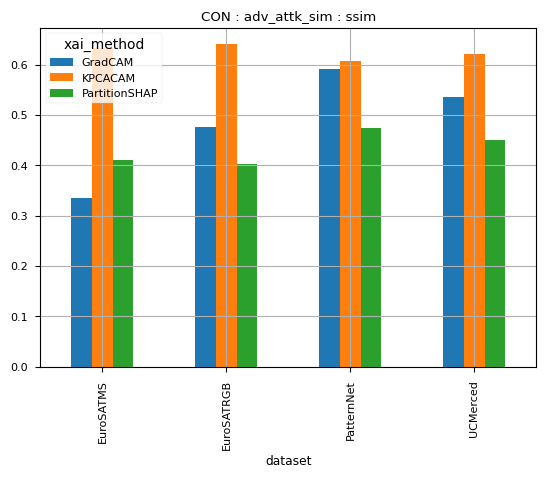

In [75]:
for col in con_df.columns:
    con_df.reset_index(level=0).pivot(columns="xai_method")[col].groupby(level=["dataset"]).mean().plot(kind="bar", grid=True, subplots=False, title=col)

The top m most important pixels barely change when informed by KPCA across all datasets.

PatternNet hard for CAM methods by all 3 metrics.

GradCAM appears to be better than SHAP on EuroSATMS, SHAP better on RGB variant. SHAP has less channel information to go on whereas the activation gradients in GradCAM might change completely for adversarial examples (by design)


 UCMerced


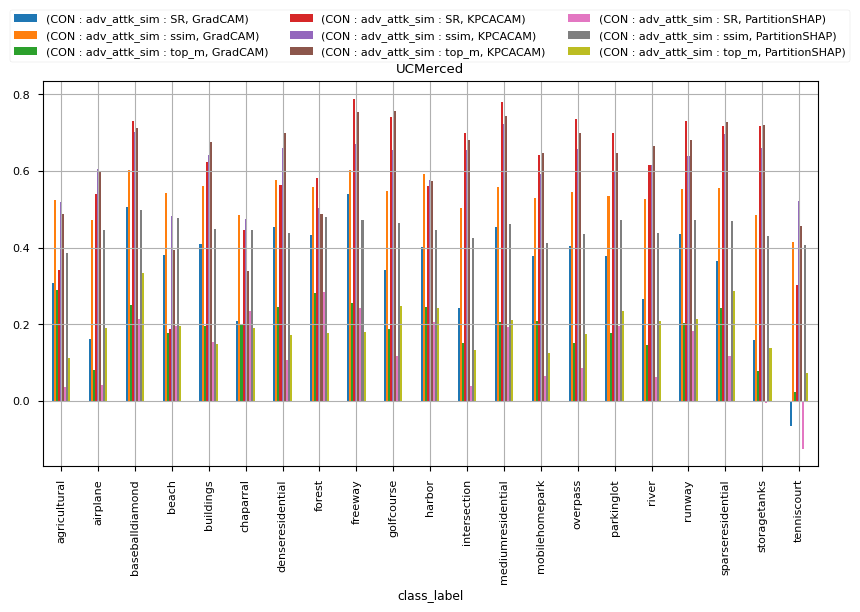


 EuroSATRGB


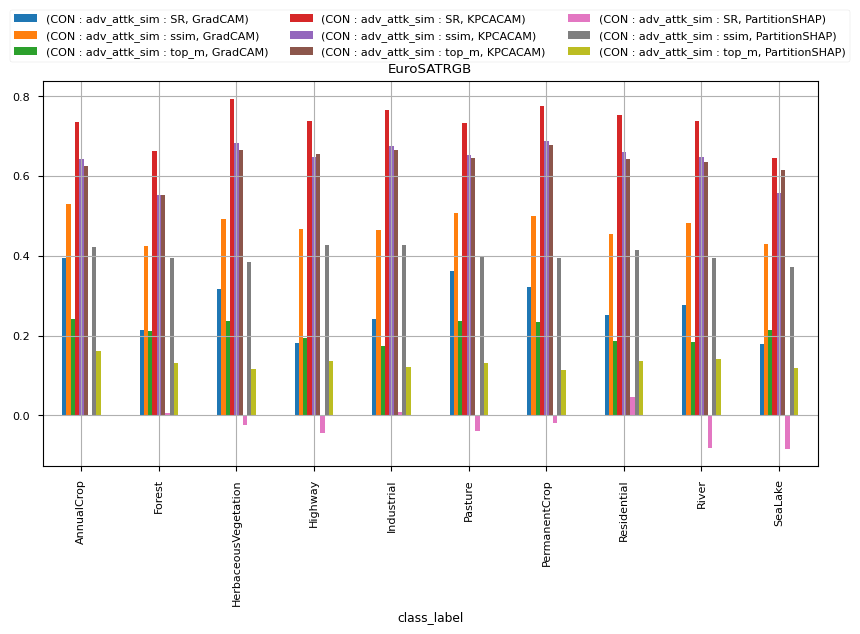


 EuroSATMS


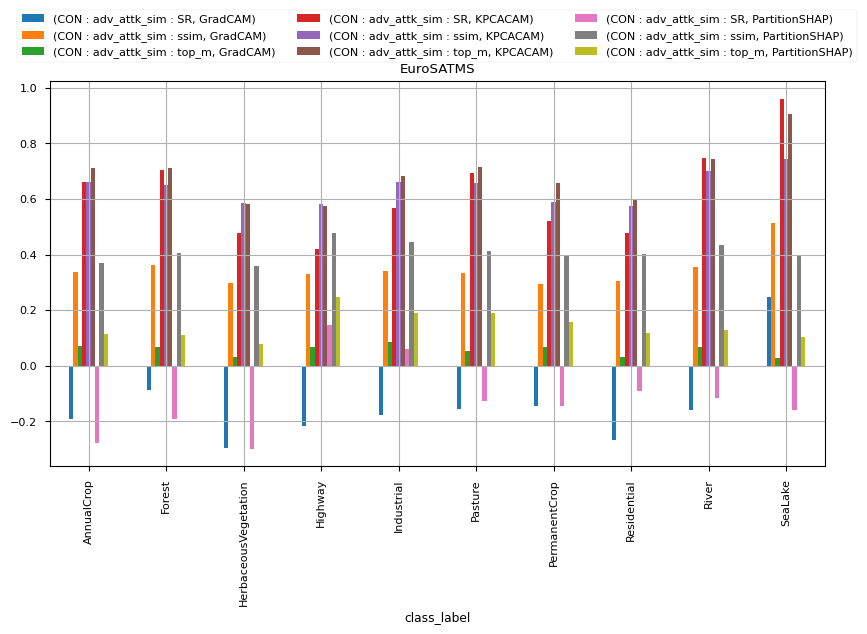


 PatternNet


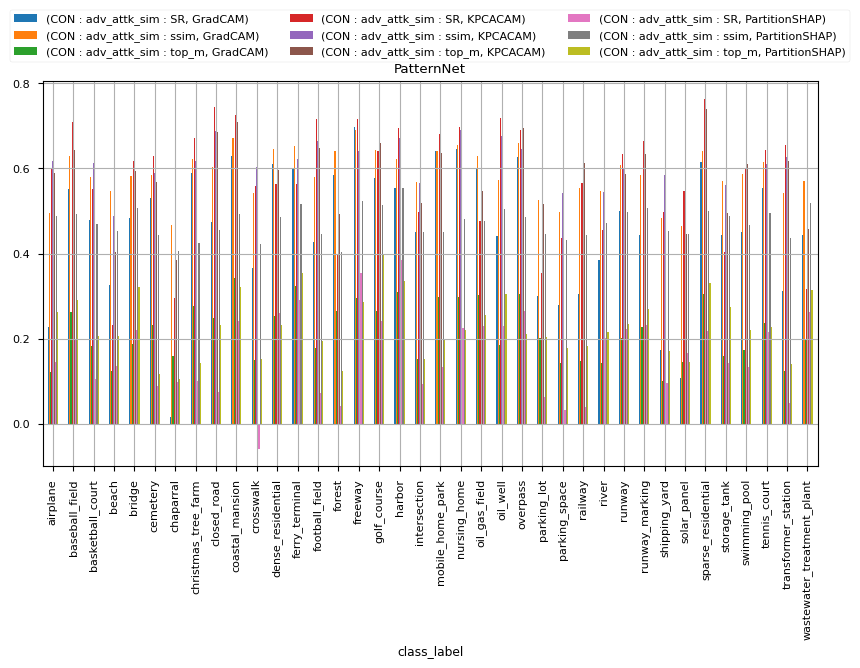

In [76]:
for ds_n in set(con_df.index.get_level_values("dataset")):
    print("\n", ds_n)
    con_df.loc[:, ds_n, :].reset_index(level=0).pivot(columns="xai_method").groupby("class_label").mean().sort_index(axis=1, level=1).plot(kind="bar", rot=90, figsize=(10, 5), grid=True, subplots=False, title=ds_n)
    plt.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, 1.2))
    plt.show()

# Compactness (threshold_score)

We want this to be high indicating a high proportion of the pixels under the threshold

Is this even valid for RS images where there are large regions which are relevant? so large portions of the image *should* be above the threshold?

In [77]:
com_cols = xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.contains("COM")]
com_df: pd.DataFrame = xai_ds_m_c_df[com_cols].copy()
com_df.columns

Index(['COM : threshold_score'], dtype='object')

In [78]:
com_df.groupby("xai_method").describe()

COM : threshold_score                                                               
                              count     mean      std      min      25%      50%      75%      max
xai_method                                                                                        
GradCAM                      237.0   0.58995  0.25143  0.10219  0.35992  0.56560  0.86373  0.94559
KPCACAM                      237.0   0.79666  0.05384  0.65198  0.76354  0.80768  0.83377  0.91085
PartitionSHAP                237.0   0.89068  0.08595  0.34302  0.85696  0.91687  0.94619  0.98865

This reflects what KPCA was designed for: more localised and compact explanations than GradCAM.

<Axes: xlabel='model'>

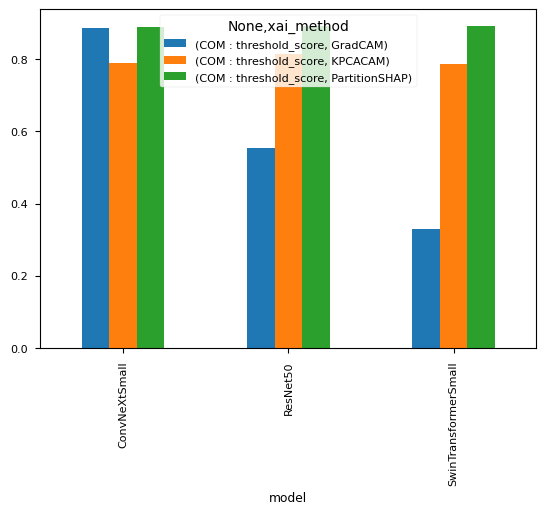

In [79]:
com_df.reset_index(level=0).pivot(columns="xai_method").groupby(["model"]).mean().plot(kind="bar")

PartitionSHAP is consistent across methods (since it's attributions approximately sum to output) as is KPCACAM.

GradCAM becomes less compact for ResNet and then even more populous for SwinTransformer - it can't focus on a few points and just highlights the whole image.

<Axes: xlabel='dataset'>

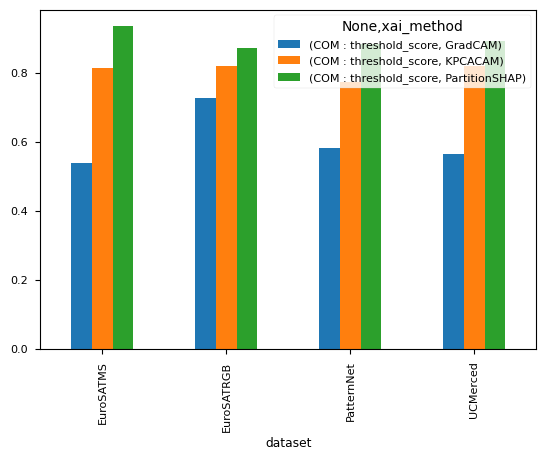

In [80]:
com_df.reset_index(level=0).pivot(columns="xai_method").groupby(["dataset"]).mean().plot(kind="bar")

<Axes: xlabel='dataset,model'>

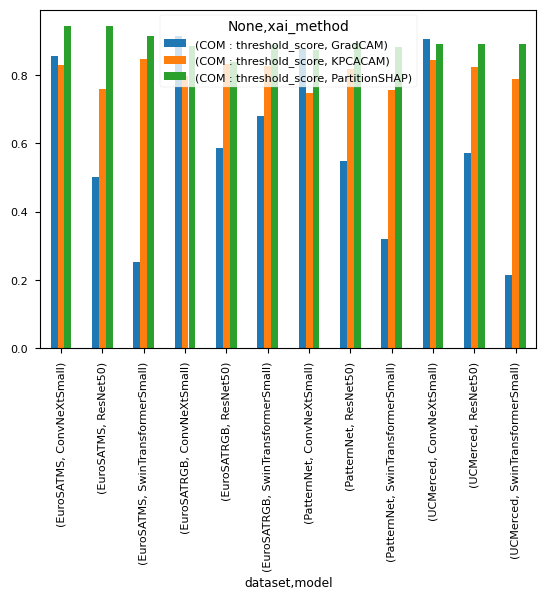

In [81]:
com_df.reset_index(level=0).pivot(columns="xai_method").groupby(["dataset", "model"]).mean().plot(kind="bar")


GradCAM does notably better on EuroSAT. Others do similarly on all datasets.